In [1]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, SecondLocator, DateFormatter

import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import scipy
import pyarrow


import aeon
import aeon.io.api as api
from aeon.io import reader, video
from aeon.schema.dataset import exp02
from aeon.analysis.utils import visits, distancetravelled

import patch
import kinematics

In [2]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import SSM.ssm as ssm
from SSM.ssm.util import find_permutation
from SSM.ssm.plots import gradient_cmap, white_to_color_cmap

sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [3]:
def DeleteRows(mouse_pos):
    mouse_pos_reset = mouse_pos.reset_index()


    grouping_var = mouse_pos_reset.groupby(mouse_pos_reset.index // 5).ngroup()
    agg_dict = {col: 'mean' for col in mouse_pos_reset.columns if col != 'time'}
    agg_dict['time'] = 'last'

    mouse_pos_grouped = mouse_pos_reset.groupby(grouping_var).agg(agg_dict)

    mouse_pos_grouped.set_index('time', inplace=True)
    mouse_pos_grouped.index.name = None
    
    return mouse_pos_grouped


In [4]:
!ls /ceph/aeon

aeon			 aeon_transfer.log  rmhzbm0  test2
aeon_transfer_final.log  db_dumps	    test


In [5]:
# Long, individual session
root = [Path("/ceph/aeon/aeon/data/raw/AEON2/experiment0.2")]

# Ensure root exists
if not np.all([path.exists() for path in root]):
    print("Cannot find root paths. Check path names or connection.")
    
Exp02Summary = api.load(root, exp02.Metadata).metadata[0].toDict()
Patch_Pos = [device['Regions']['ArrayOfPoint'] for device in Exp02Summary['Devices'] if device['Name'].startswith('ActivityPatch')]

subject_events = api.load(root, exp02.ExperimentalMetadata.SubjectState)
sessions = visits(subject_events[subject_events.id.str.startswith("BAA-")])

# Choose Valid Sessions

In [6]:
sessions_ = sessions.iloc[[4,8,10,11,14,16,17,20,23,24,25,26,28,29,30,31]]
short_sessions = sessions.iloc[[4,16,17,20,23,24,25,26,28,29,30,31]]
long_sessions = sessions.iloc[[8, 10, 11, 14]]

In [ ]:
'''short_sessions_patch1, short_sessions_patch2 = [],[]
for session, j in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    title = 'ShortSession'+str(j)
    print(title)
    mouse_pos = pd.read_parquet(title+'mousepos.parquet', engine='pyarrow')
    mouse_pos = mouse_pos[mouse_pos['smoothed_acceleration'] <= 60000]
    mouse_pos = DeleteRows(mouse_pos)
    
    x = mouse_pos['smoothed_position_x']
    y = mouse_pos['smoothed_position_y']
    speed = mouse_pos['smoothed_speed']
    acceleration = mouse_pos['smoothed_acceleration']
    VisitPatch1 = mouse_pos['Patch1']
    VisitPatch2 = mouse_pos['Patch2']
    Patch_Pref = 1 if np.mean(VisitPatch1) > np.mean(VisitPatch2) else 2
    Patch_UnPref = 1 if np.mean(VisitPatch1) < np.mean(VisitPatch2) else 2
    
    if Patch_Pref == 1: short_sessions_patch1.append(j)
    else: short_sessions_patch2.append(j)'''

In [7]:
short_sessions_patch1 = [1, 2, 3, 4, 7, 8, 9, 10, 11]
short_sessions_patch2 = [0,5,6]

# Fit HMM

In [8]:
def PlotLLS(hmm_lls):
    plt.plot(hmm_lls, label="EM")
    #plt.plot([0, N_iters], true_ll * np.ones(2), ':k', label="True")
    plt.xlabel("EM Iteration")
    plt.ylabel("Log Probability")
    plt.legend(loc="lower right")
    plt.show()

#color_names = ["windows blue","red","amber", "faded green","dusty purple","orange"]
color_names = ["blue","red","yellow", "green","white"]
colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

def PlotStates(hmm_z, mouse_pos):
    times = pd.to_datetime(mouse_pos.index)
    numerical_times = (times - times[0]).total_seconds().values
    states_array = hmm_z.reshape(1, -1)
    
    fig, axs = plt.subplots(1, 1, figsize=(35, 4))
    extent = [numerical_times[0], numerical_times[-1], 0, 1]
    cax = axs.imshow(states_array, aspect="auto", cmap=cmap, vmin=0, vmax=np.max(states_array), extent=extent)
    
    axs.set_xlabel('Time')
    axs.set_xticks(numerical_times[::len(numerical_times)//10])
    axs.set_xticklabels([time.strftime('%H:%M:%S') for time in times[::len(times)//10]], rotation=45, ha='right')
    
    axs.set_ylabel("States")
    axs.set_yticks([])

    cbar = fig.colorbar(cax, ax=axs, orientation='vertical')
    cbar.set_ticks(np.arange(0, np.max(hmm_z) + 1))
    cbar.set_ticklabels([f'State {val}' for val in np.arange(0, np.max(hmm_z) + 1)])
    
    plt.tight_layout()
    plt.show()


def PlotTransition(transition_mat):
    annot_array = np.array([[round(item, 2) for item in row] for row in transition_mat])
    fig, axs = plt.subplots(1,1, figsize=(4, 4))
    sns.heatmap(transition_mat, cmap='YlGnBu', ax = axs, square = 'True', cbar = False, annot=annot_array)
    axs.set_title("Learned Transition Matrix")
    plt.show()  

def FitHMM(data, num_states, n_iters = 50):
    obs_dim = len(data[0])
    hmm = ssm.HMM(num_states, obs_dim, observations="gaussian")
    
    lls = hmm.fit(data, method="em", num_iters=n_iters, init_method="kmeans")
    states = hmm.most_likely_states(data)
    transition_mat = hmm.transitions.transition_matrix
    
    return hmm, states, transition_mat, lls

## Short Sessions

In [7]:
# Compute and Save Patch Information
'''for session, i in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    title = 'ShortSession'+str(i)
    print(title)
                
    start, end = session.enter, session.exit
    mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)
            
    temp_df = mouse_pos.dropna(subset=['x', 'y'])
    first_valid_index = temp_df.index[0]
    last_valid_index = temp_df.index[-1]
    mouse_pos = mouse_pos.loc[first_valid_index:last_valid_index]
    mouse_pos = kinematics.FixNan(mouse_pos)
        
    start, end = mouse_pos.index[0], mouse_pos.index[-1]
            
    patch.AddKinematics(title, mouse_pos)
    mouse_pos = mouse_pos[mouse_pos['smoothed_speed'] <= 2000]
        
    weight = api.load(root, exp02.Nest.WeightSubject, start=start, end=end)
    patch.AddWeight(mouse_pos, weight)
        
    pellets_patch1 = api.load(root, exp02.Patch1.DeliverPellet, start=start, end=end)
    pellets_patch2 = api.load(root, exp02.Patch2.DeliverPellet, start=start, end=end)
            
    patch.InPatch(mouse_pos, pellets_patch1, pellets_patch2)
    
    mouse_pos.to_parquet(title+'mousepos.parquet', engine='pyarrow')'''

"for session, i in zip(list(short_sessions.itertuples()), range(len(short_sessions))):\n    title = 'ShortSession'+str(i)\n    print(title)\n                \n    start, end = session.enter, session.exit\n    mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)\n            \n    temp_df = mouse_pos.dropna(subset=['x', 'y'])\n    first_valid_index = temp_df.index[0]\n    last_valid_index = temp_df.index[-1]\n    mouse_pos = mouse_pos.loc[first_valid_index:last_valid_index]\n    mouse_pos = kinematics.FixNan(mouse_pos)\n        \n    start, end = mouse_pos.index[0], mouse_pos.index[-1]\n            \n    patch.AddKinematics(title, mouse_pos)\n    mouse_pos = mouse_pos[mouse_pos['smoothed_speed'] <= 2000]\n        \n    weight = api.load(root, exp02.Nest.WeightSubject, start=start, end=end)\n    patch.AddWeight(mouse_pos, weight)\n        \n    pellets_patch1 = api.load(root, exp02.Patch1.DeliverPellet, start=start, end=end)\n    pellets_patch2 = api.load(root, exp0

### Determining Number of States

In [10]:
S = []

for n in range(3,10,1):
    N = n
    print(n)
    
    feature = ['weight', 'smoothed_speed', 'smoothed_acceleration']
    LL = []

    for k in range(len(short_sessions)):
        title = 'ShortSession'+str(k)
        
        mouse_pos = pd.read_parquet(title+'mousepos.parquet', engine='pyarrow')
        mouse_pos = mouse_pos[mouse_pos['smoothed_acceleration'] <= 60000]
        mouse_pos = DeleteRows(mouse_pos)
                
        obs = np.array(mouse_pos[feature])
        hmm, states, transition_mat, lls = FitHMM(obs, num_states = N, n_iters = 50)
        ll = []

        for session, j in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
            title = 'ShortSession'+str(j)
            mouse_pos = pd.read_parquet(title+'mousepos.parquet', engine='pyarrow')
            mouse_pos = mouse_pos[mouse_pos['smoothed_acceleration'] <= 60000]
            mouse_pos = DeleteRows(mouse_pos)
                
            obs = np.array(mouse_pos[feature])
            states = hmm.most_likely_states(obs)
                
            ll.append(hmm.log_likelihood(obs))
            
        LL.append(np.mean(ll))

    S.append(LL)

3


/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

4


/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

5


/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

6


/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

7


/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

8


/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

9


/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

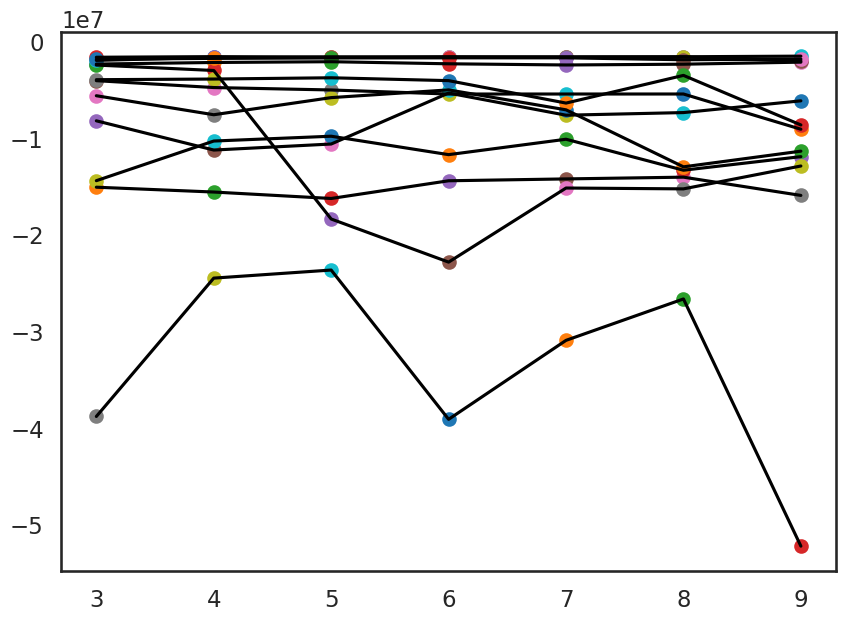

In [30]:
fig, axs = plt.subplots(1,1,figsize = (10,7))
s = np.mean(S, axis = 1)
for number in range(0, 12):
    for n, ll in zip(range(3,10,1), S):
        nn = [n for i in range(len(ll))]
        axs.scatter(nn[number], ll[number])
    axs.plot(np.arange(3,10,1), np.array(S).T[number], color = 'black')
axs.set_xticks(np.arange(3,10,1))
plt.show()

In [27]:
np.array(S).T[7]

array([-1942288.37662314, -1631020.6194349 , -1576549.72392068,
       -1603629.05789709, -1579011.34138309, -1583875.16870246,
       -2000668.39756268])

### Determining Model Session

In [ ]:
# 0, LL_mean = -215,7353.0
# 1, LL_mean = -2446,6969.0
# 2, LL_mean = -1122,1029.0
# 3, LL_mean = -1556,2783.0
# 4, LL_mean = -1011,3747.0
# 5, LL_mean = -500,7014.0
# 6, LL_mean = -298,6088.0
# 7, LL_mean = -163,4606.0
# 8, LL_mean = -537,1325.0
# 9, LL_mean = -155,2906.0
# 10, LL_mean = -173,5715.0
# 11, LL_mean = -387,0867.0

'''N = 4
feature = ['weight', 'smoothed_speed', 'smoothed_acceleration']
LL = []

for k in range(len(short_sessions)):
    title = 'ShortSession'+str(k)
    print(title)
    mouse_pos = pd.read_parquet(title+'mousepos.parquet', engine='pyarrow')
    mouse_pos = mouse_pos[mouse_pos['smoothed_acceleration'] <= 60000]
    mouse_pos = DeleteRows(mouse_pos)
            
    obs = np.array(mouse_pos[feature])
    hmm, states, transition_mat, lls = FitHMM(obs, num_states = N, n_iters = 50)
    ll = []

    for session, j in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
        title = 'ShortSession'+str(j)
        mouse_pos = pd.read_parquet(title+'mousepos.parquet', engine='pyarrow')
        mouse_pos = mouse_pos[mouse_pos['smoothed_acceleration'] <= 60000]
        mouse_pos = DeleteRows(mouse_pos)
            
        obs = np.array(mouse_pos[feature])
        states = hmm.most_likely_states(obs)
            
        ll.append(hmm.log_likelihood(obs))
        
    LL.append(ll)

fig, axs = plt.subplots(1, 1, figsize = (6,5))
sns.heatmap(LL, ax = axs, cmap = 'YlGnBu', square=True)
plt.show()'''

### Fit the model using one session: session 7

ShortSession7


/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

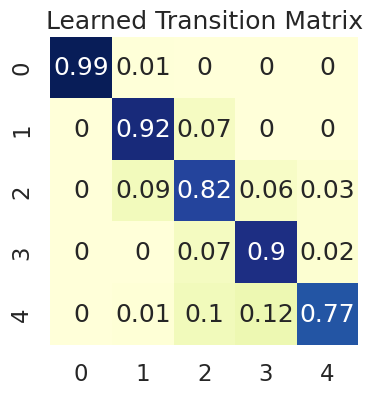

In [64]:
N = 5
feature = ['weight', 'smoothed_speed', 'smoothed_acceleration']

title = 'ShortSession'+str(7)
print(title)
mouse_pos = pd.read_parquet(title+'mousepos.parquet', engine='pyarrow')
mouse_pos = mouse_pos[mouse_pos['smoothed_acceleration'] <= 60000]
mouse_pos = DeleteRows(mouse_pos)
        
obs = np.array(mouse_pos[feature])
hmm, states, transition_mat, lls = FitHMM(obs, num_states = N, n_iters = 50)

state_mean_speed = hmm.observations.params[0].T[1]
index = np.argsort(state_mean_speed, -1)
        
PlotTransition(transition_mat[index].T[index].T)

ShortSession1


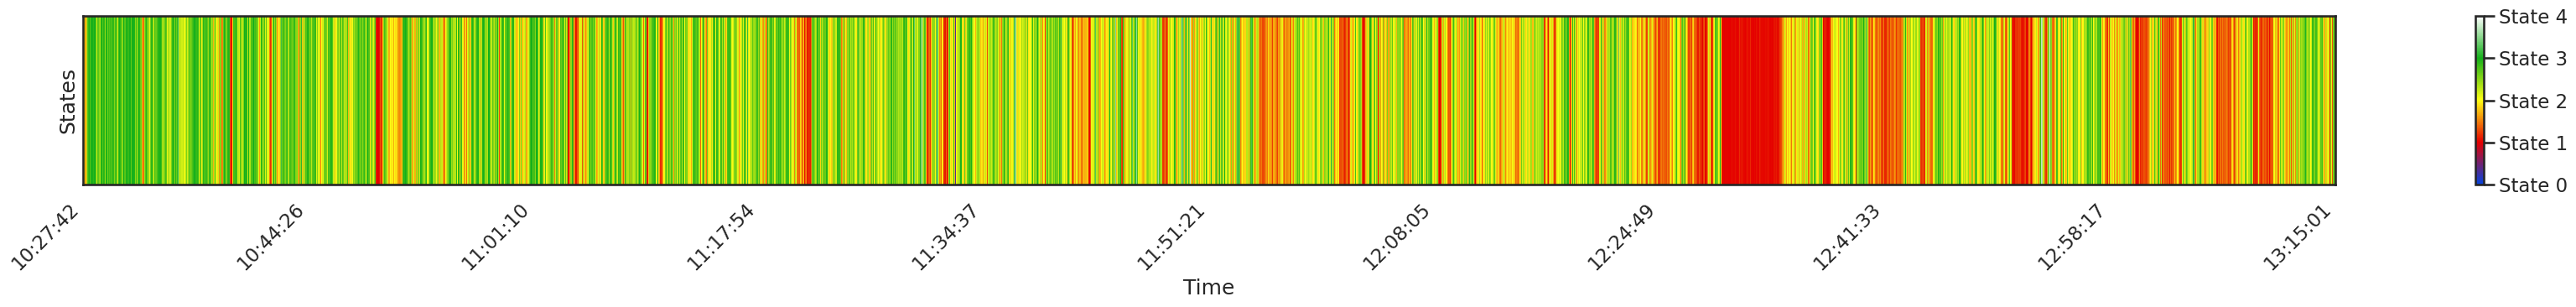

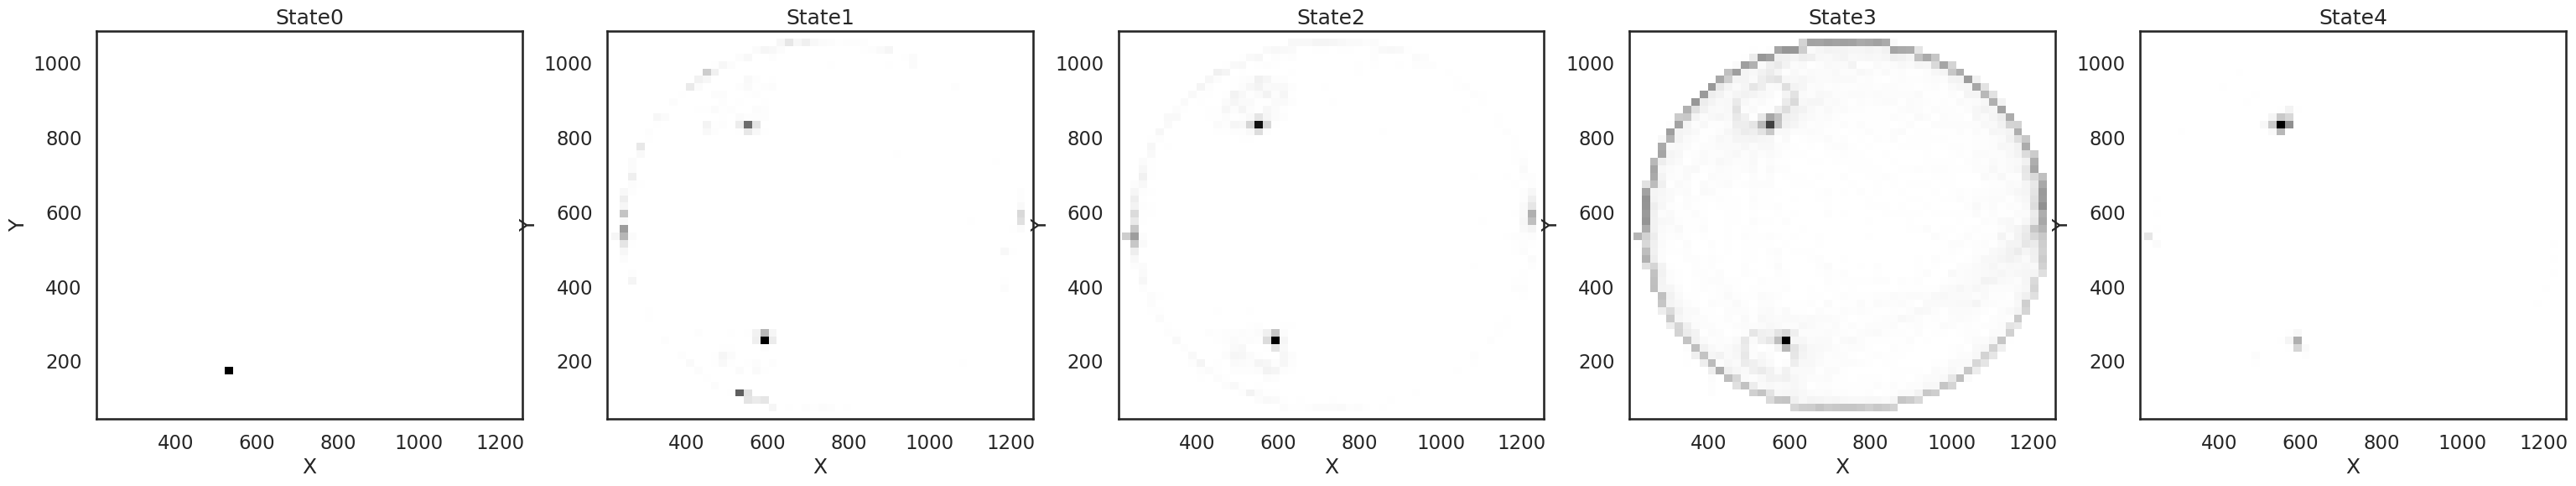

ShortSession2


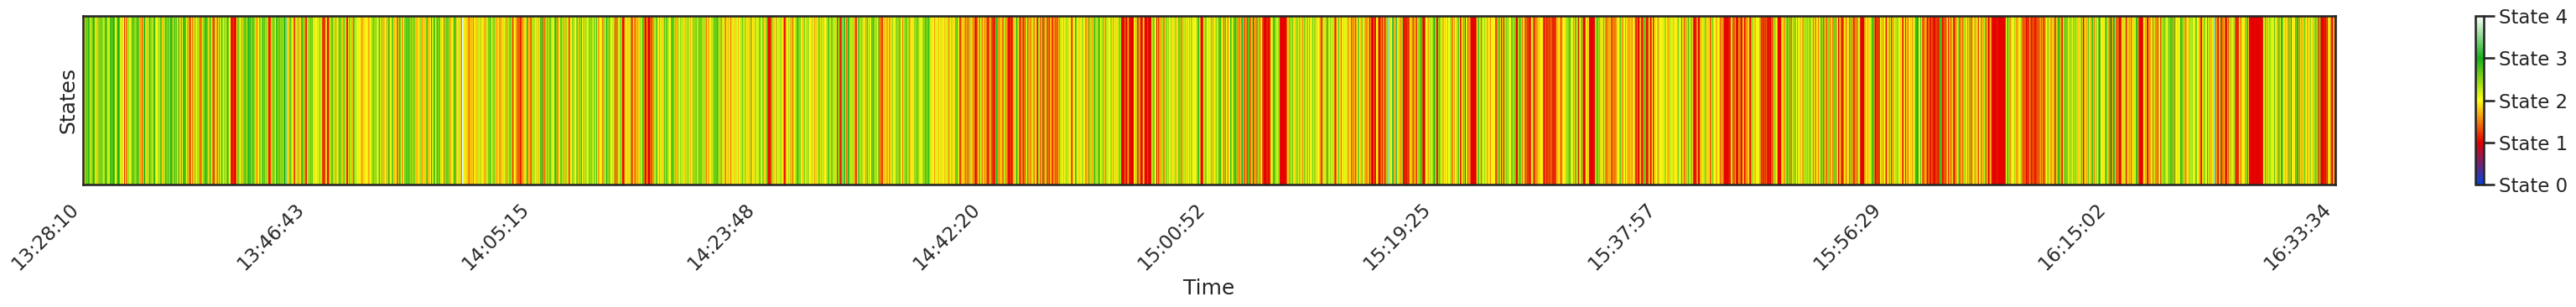

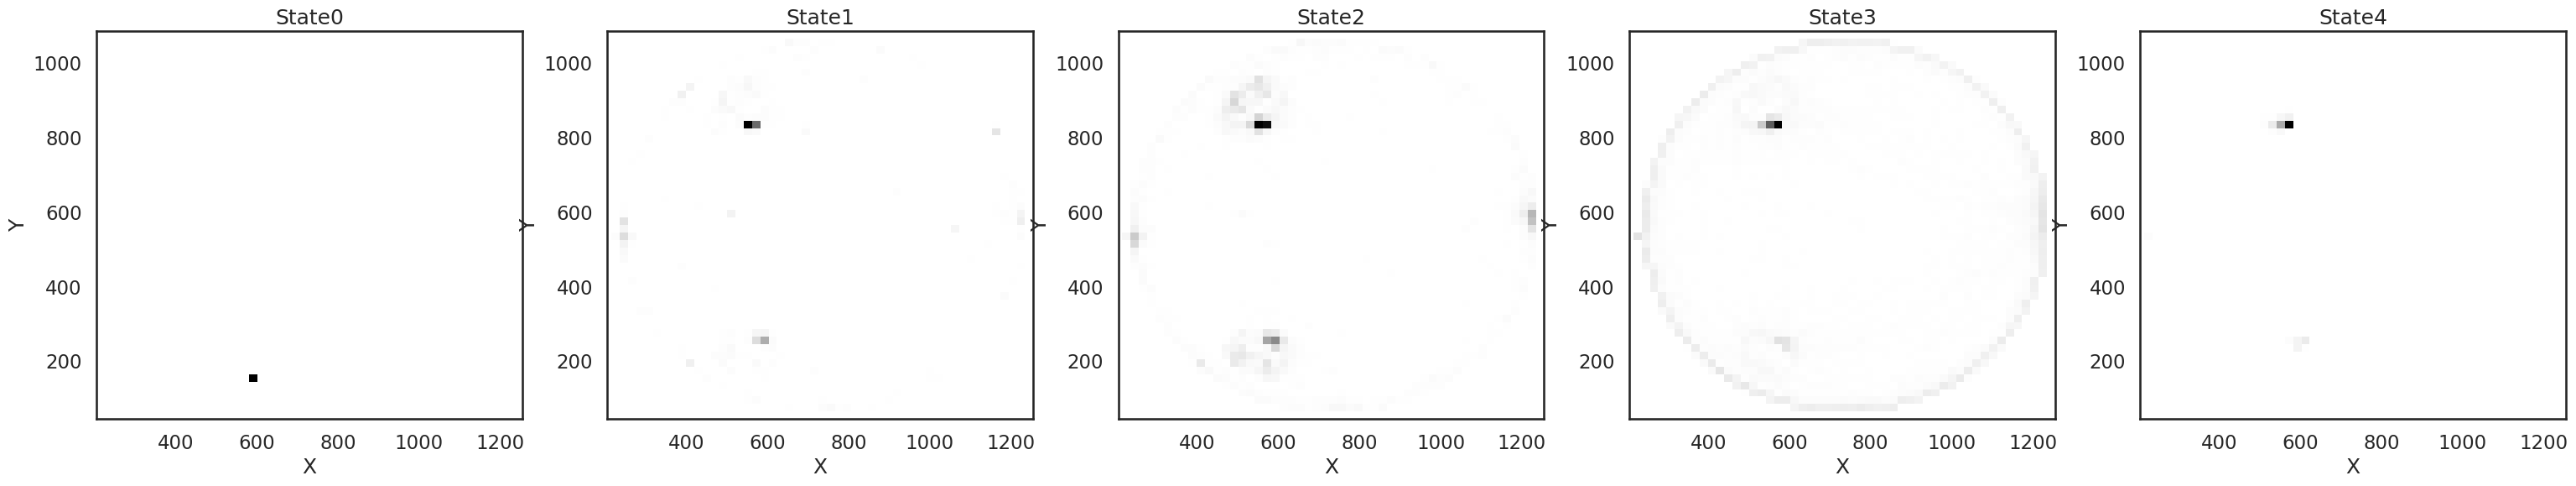

ShortSession3


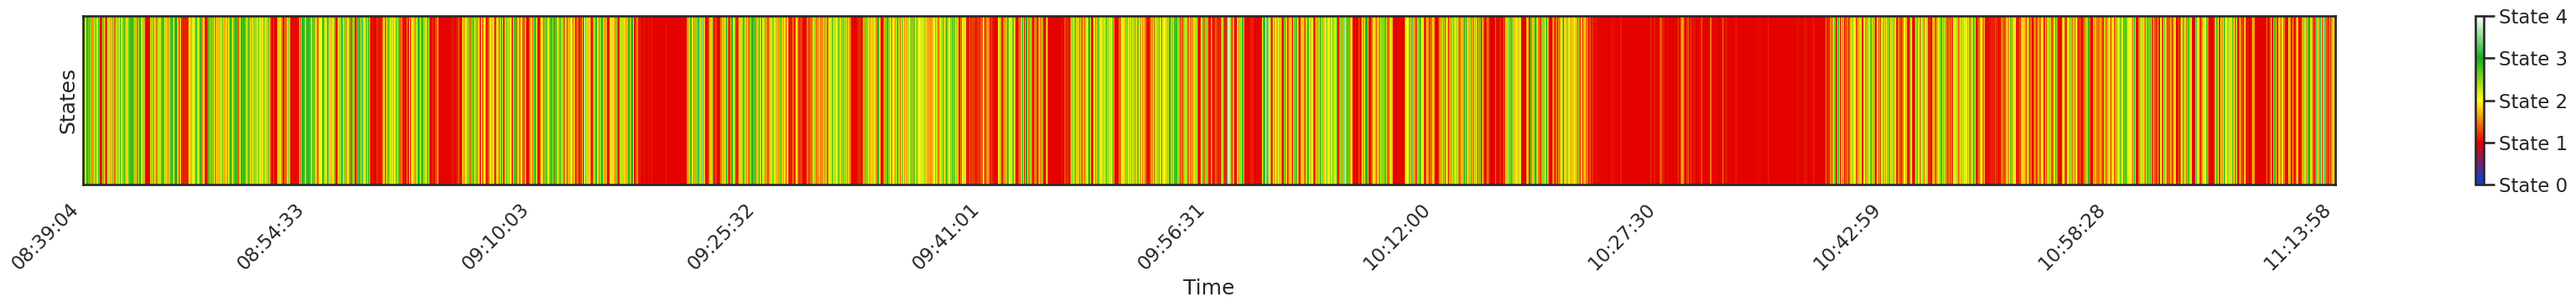

/nfs/nhome/live/zimol/anaconda3/envs/lds/lib/python3.9/site-packages/numpy/lib/histograms.py:1124: RuntimeWarning: invalid value encountered in true_divide
  hist /= s


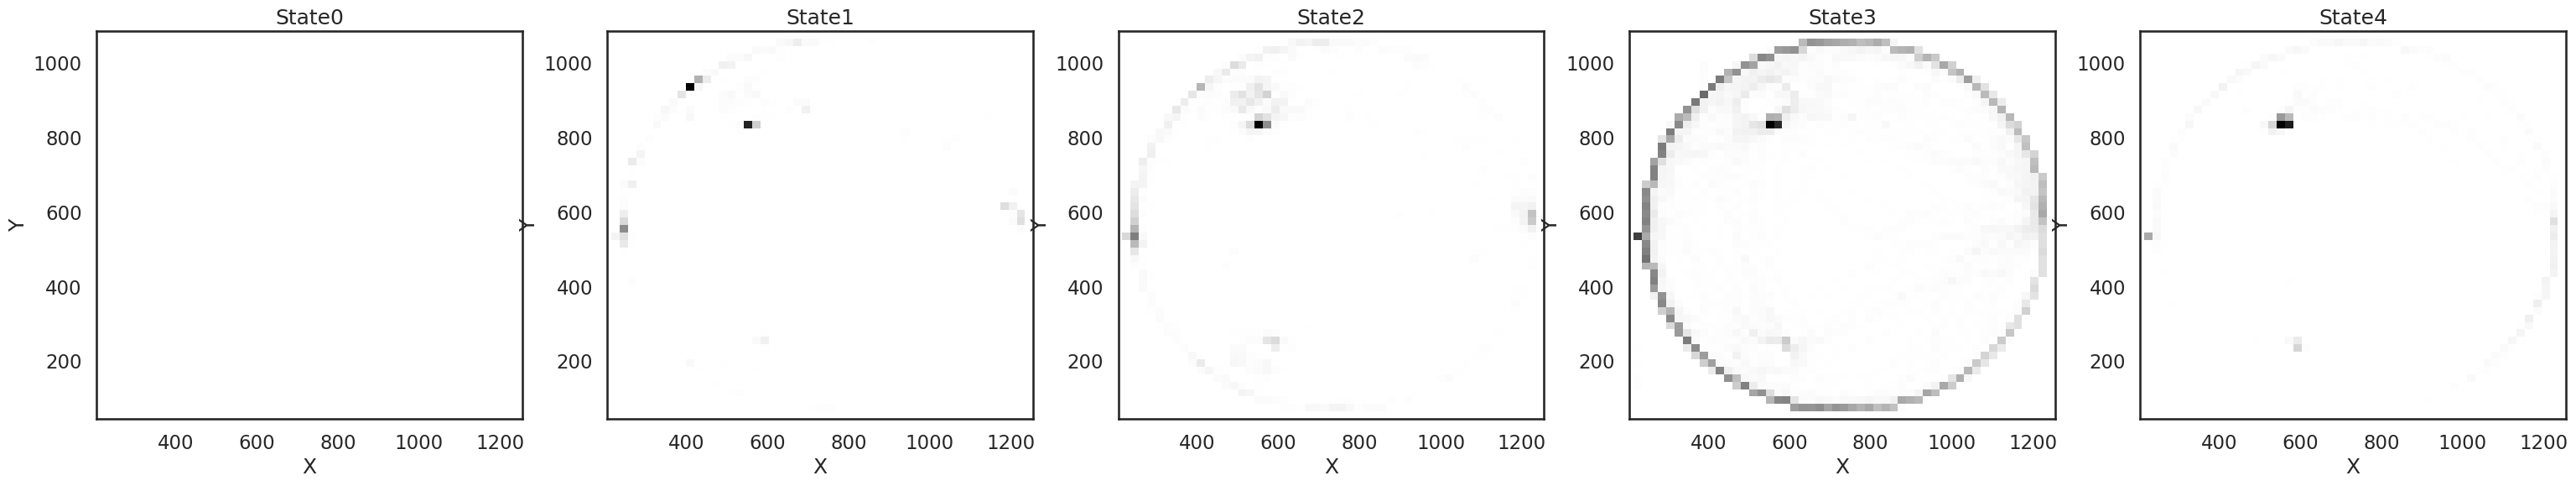

ShortSession4


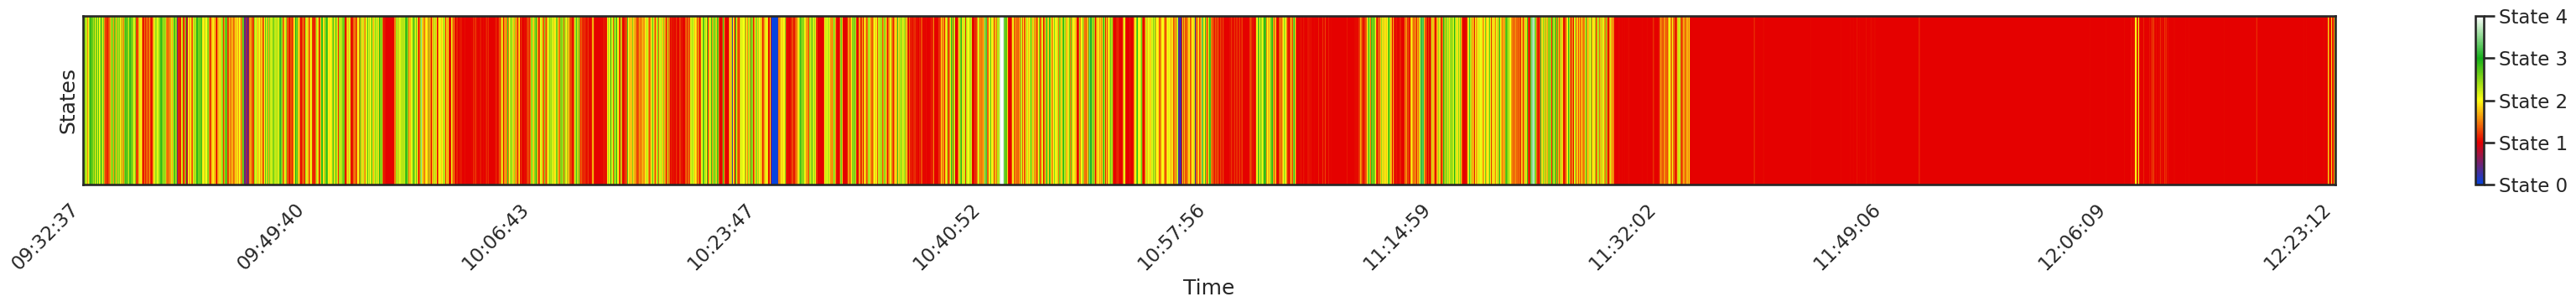

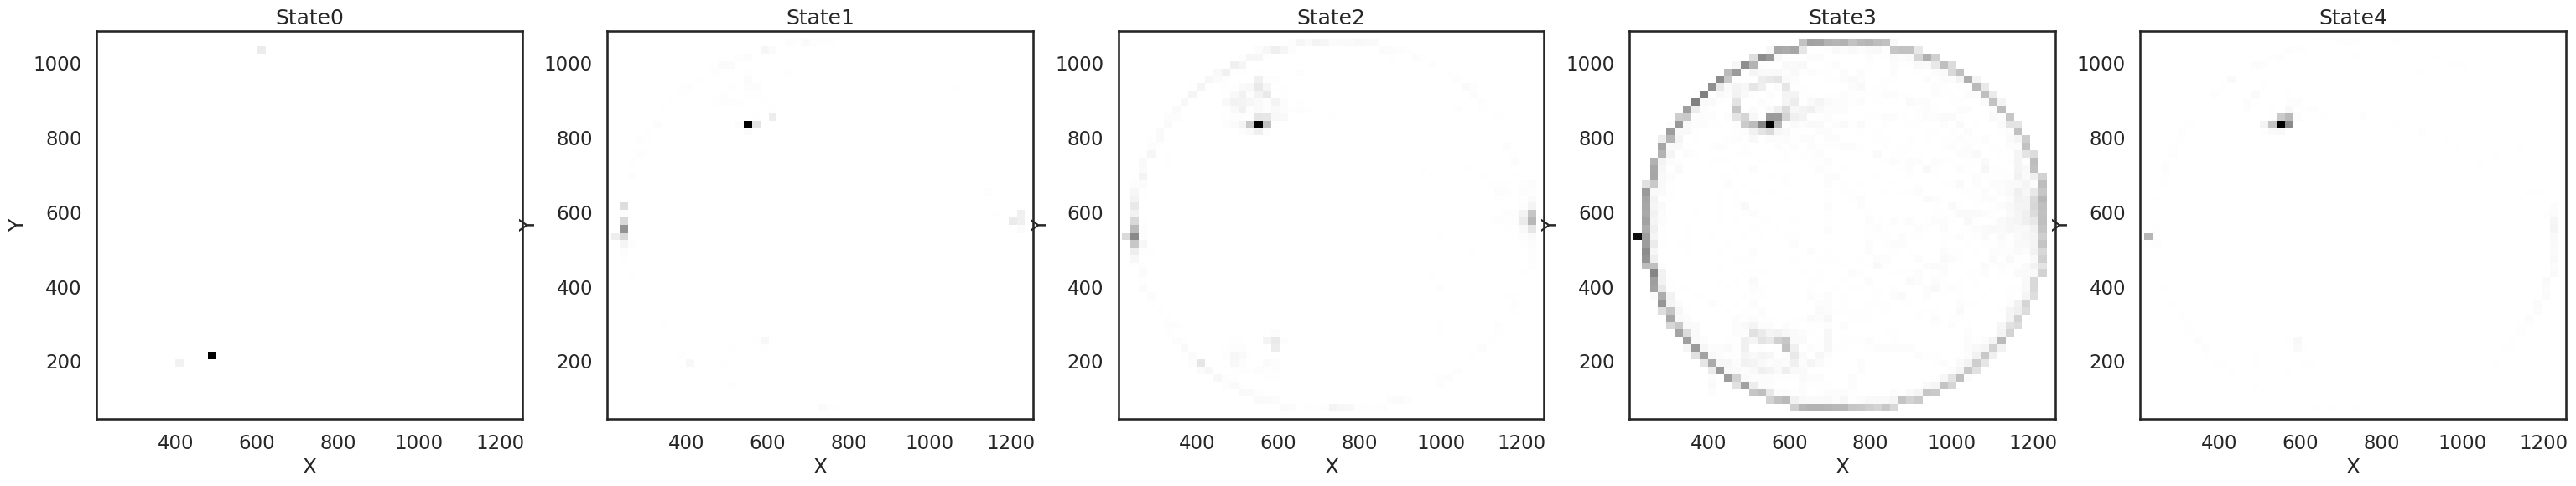

ShortSession7


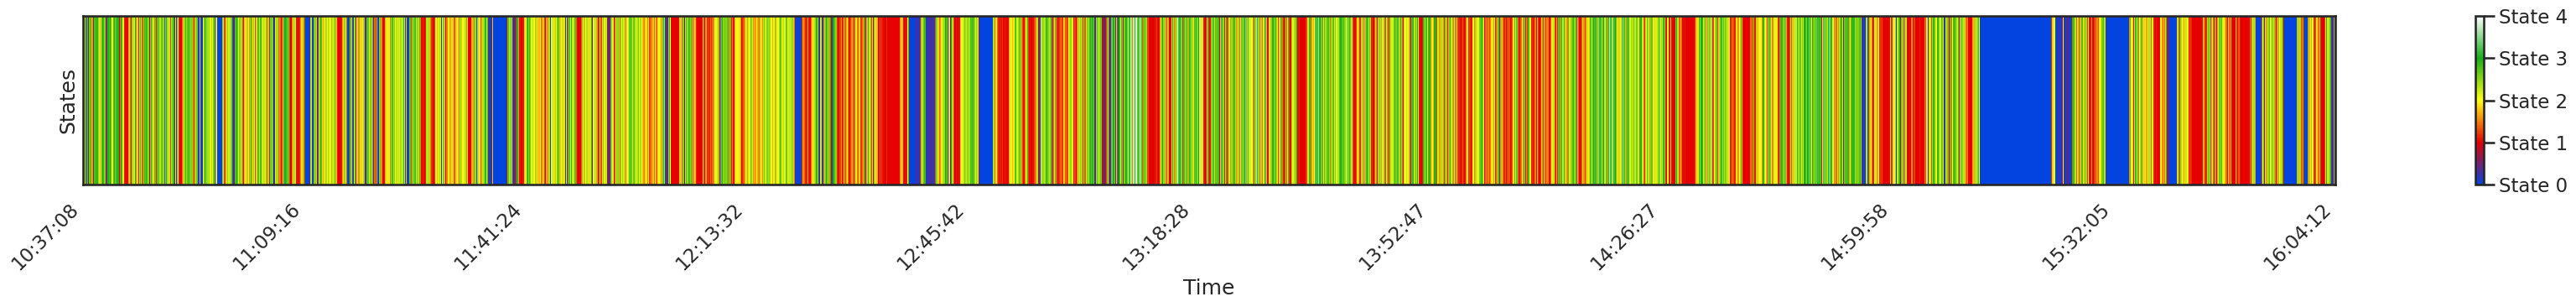

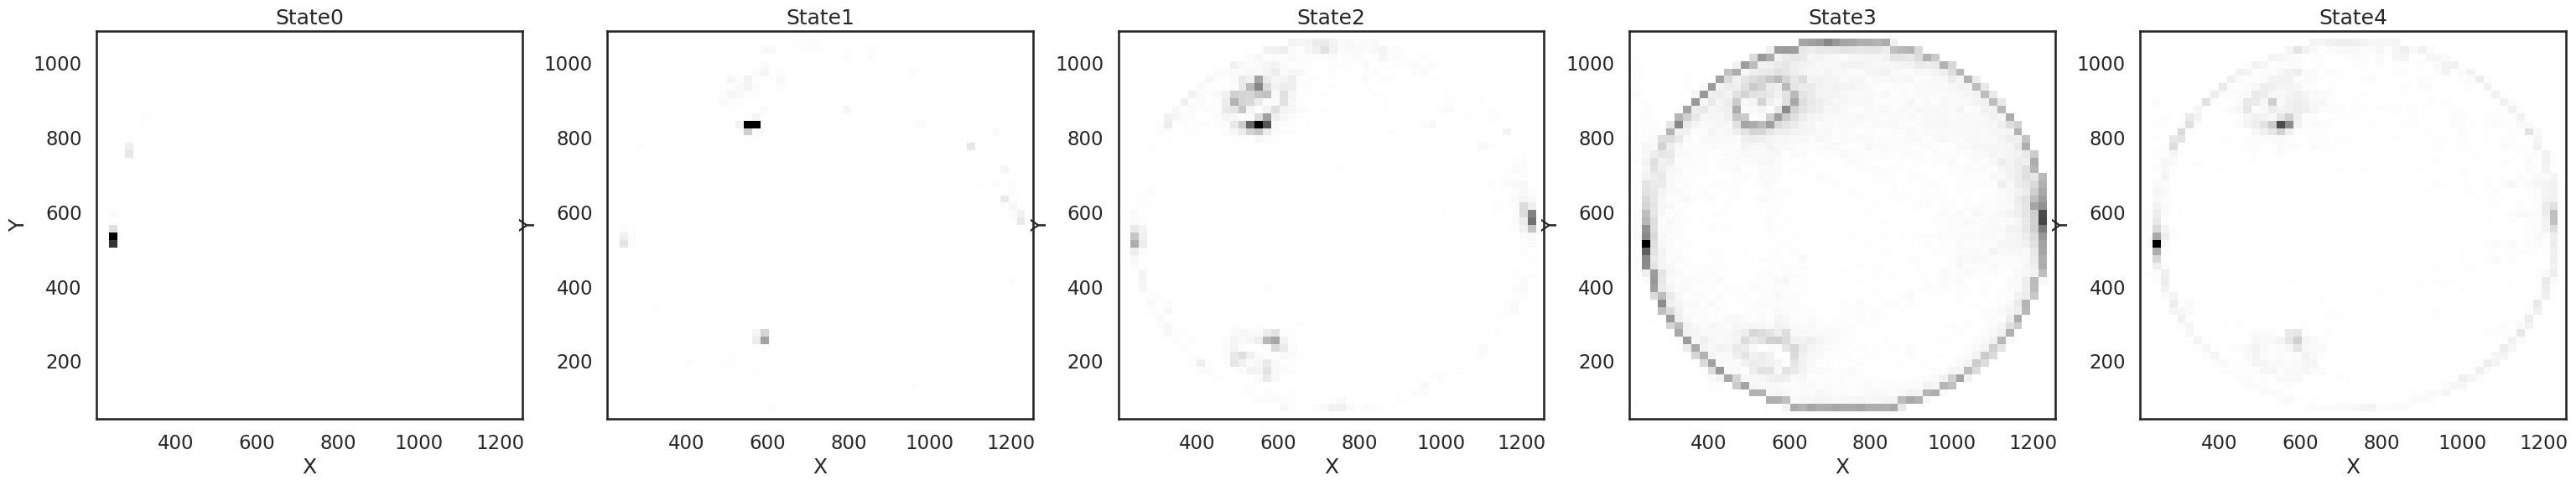

ShortSession8


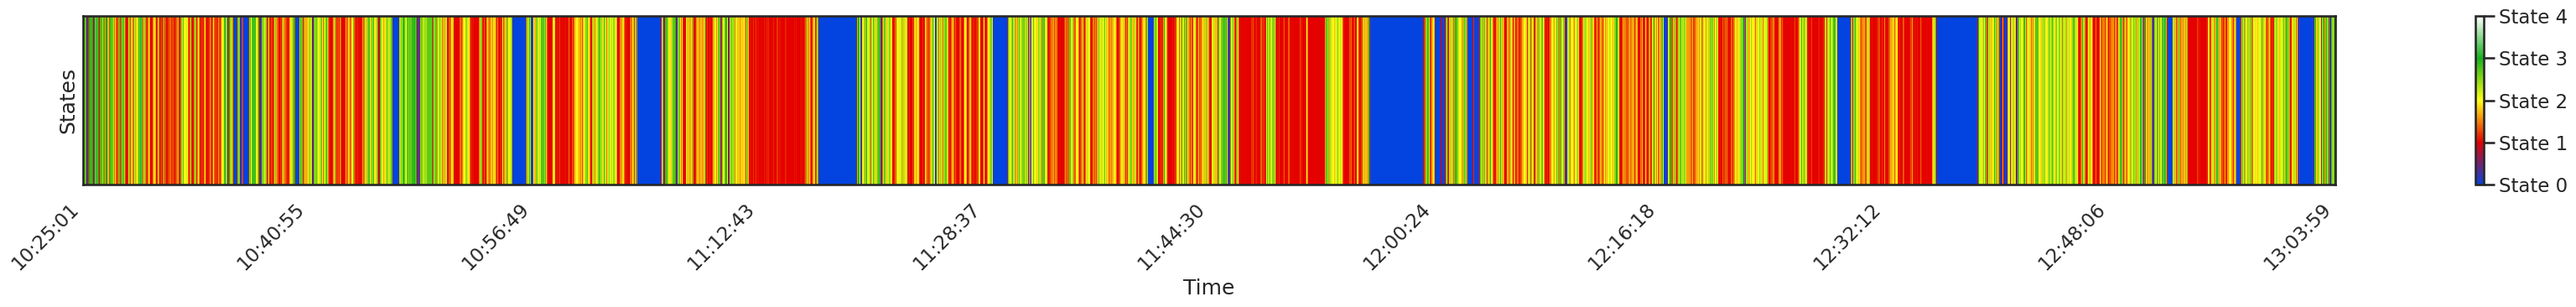

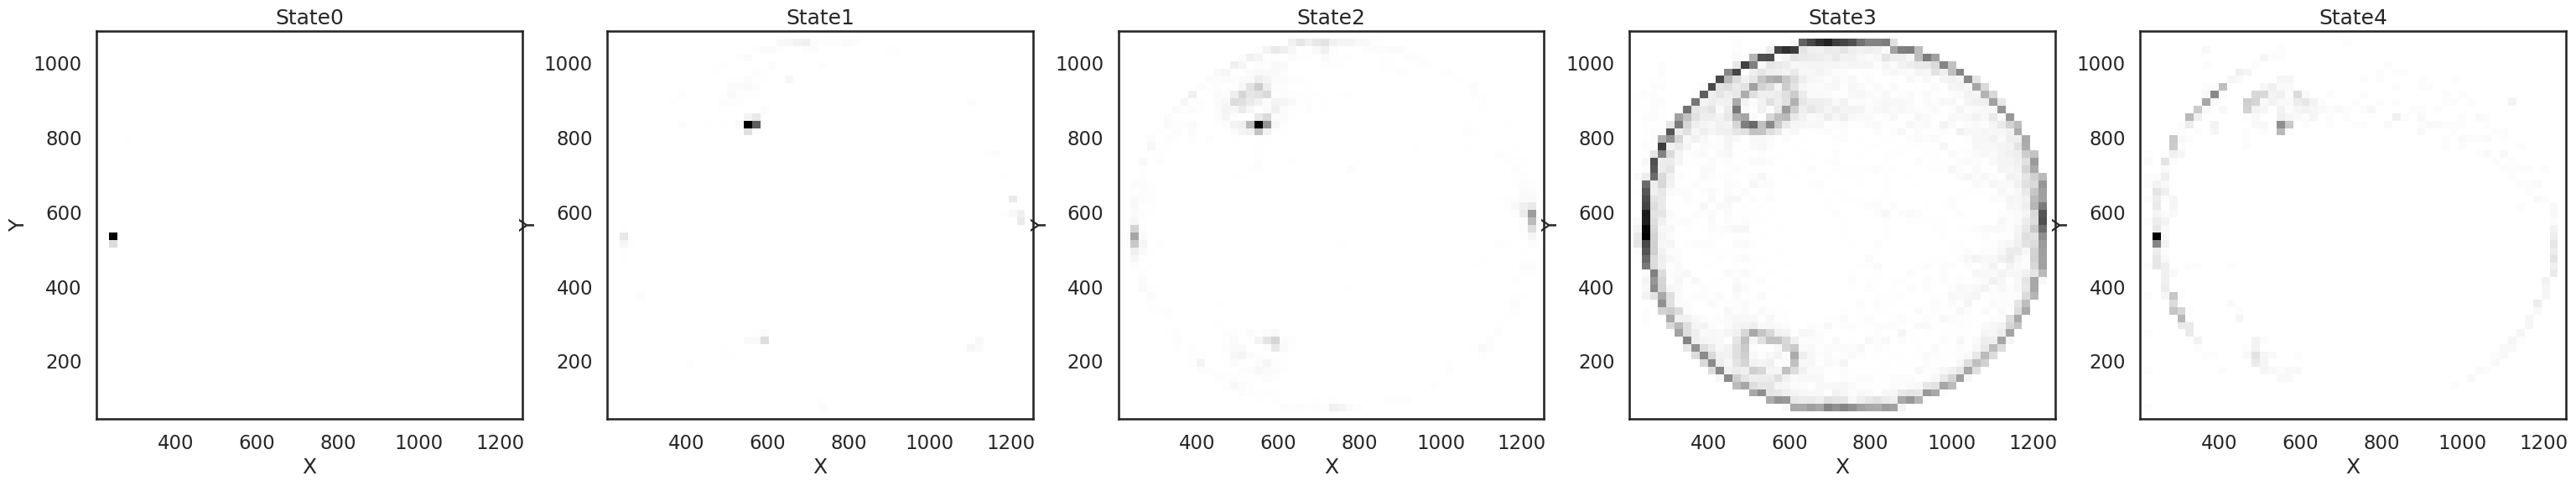

ShortSession9


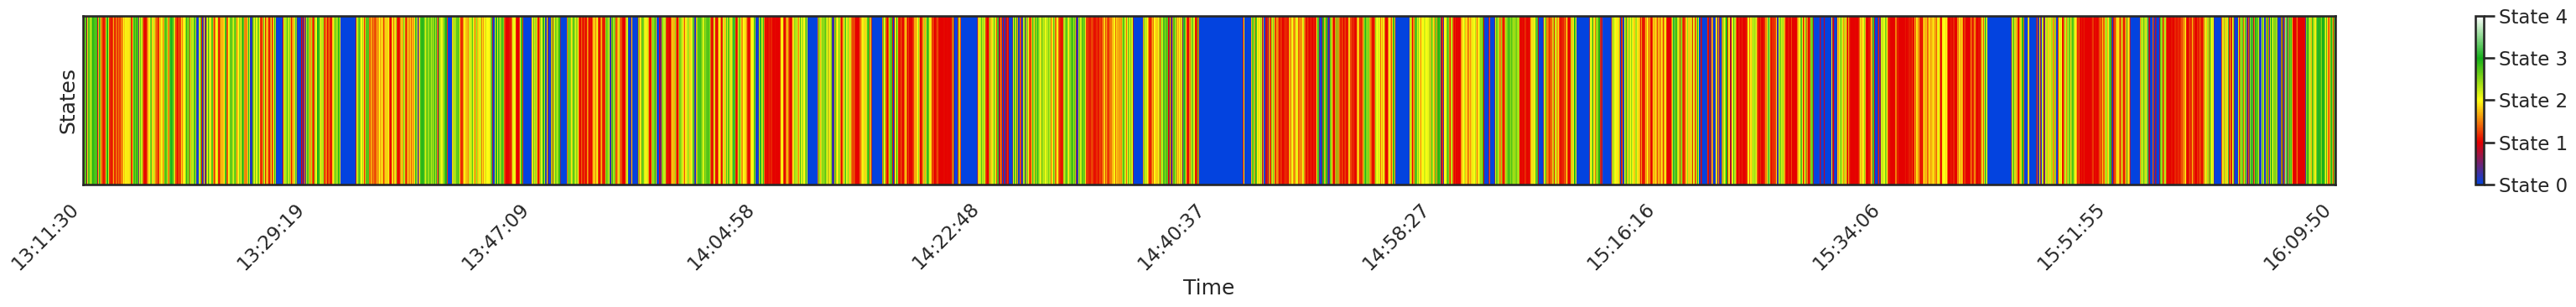

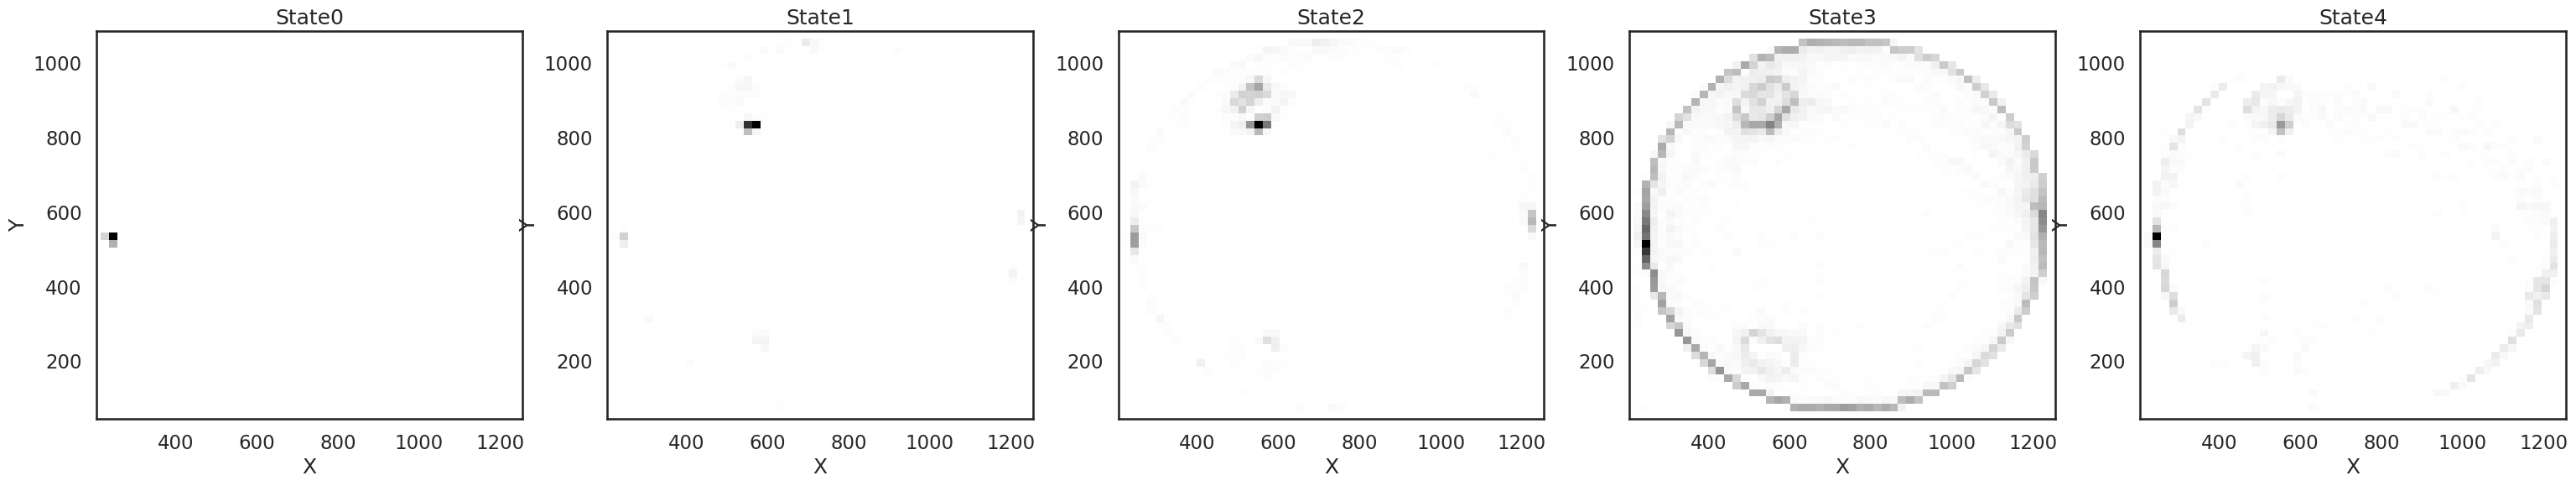

ShortSession10


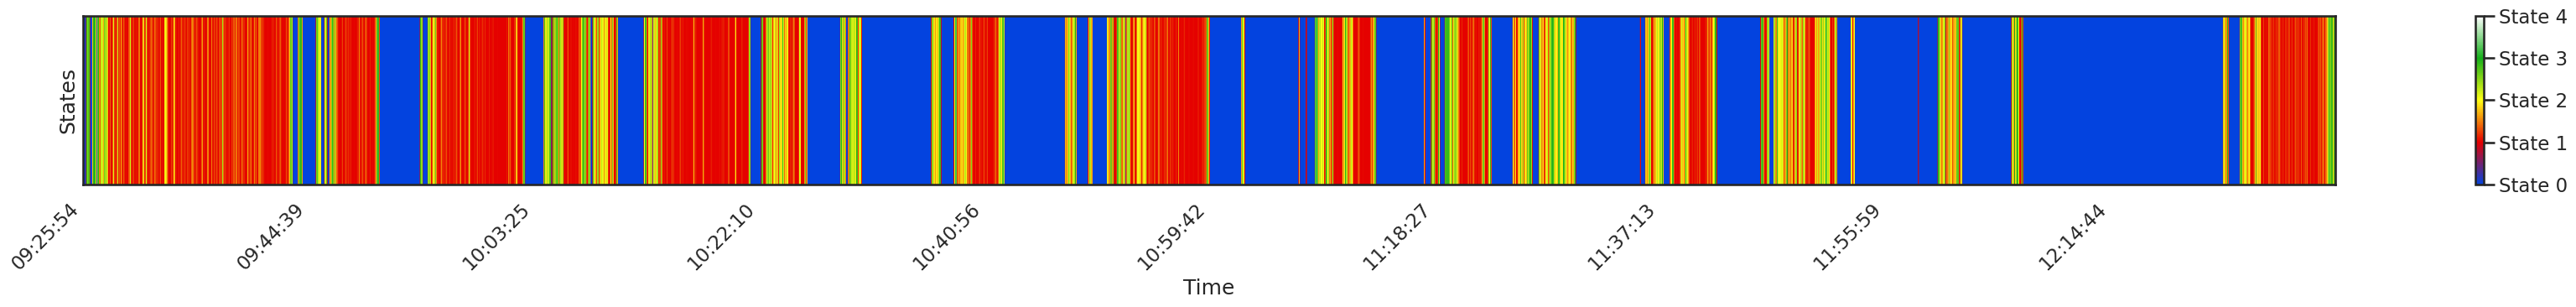

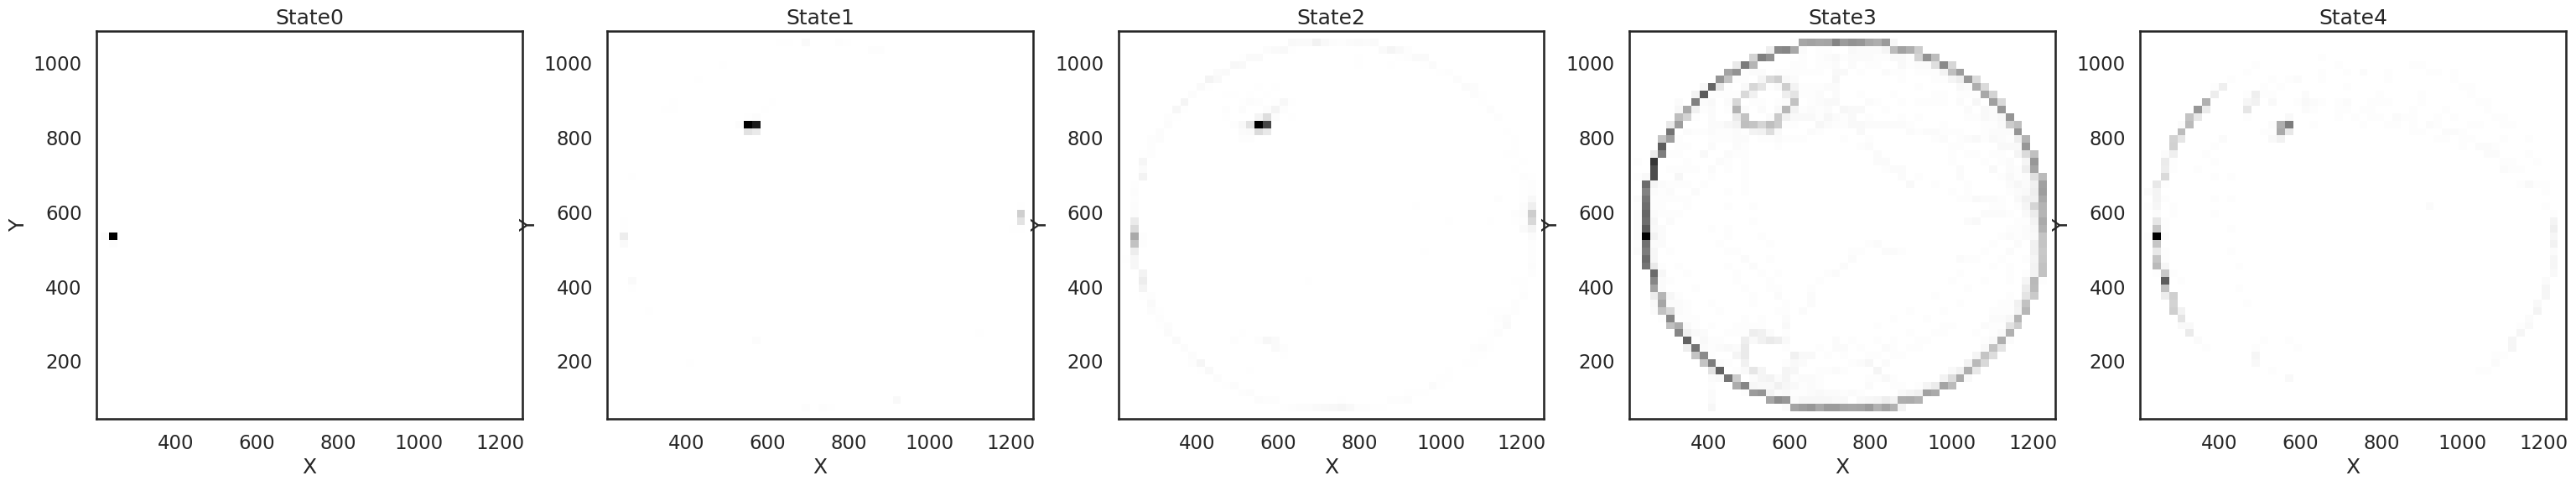

ShortSession11


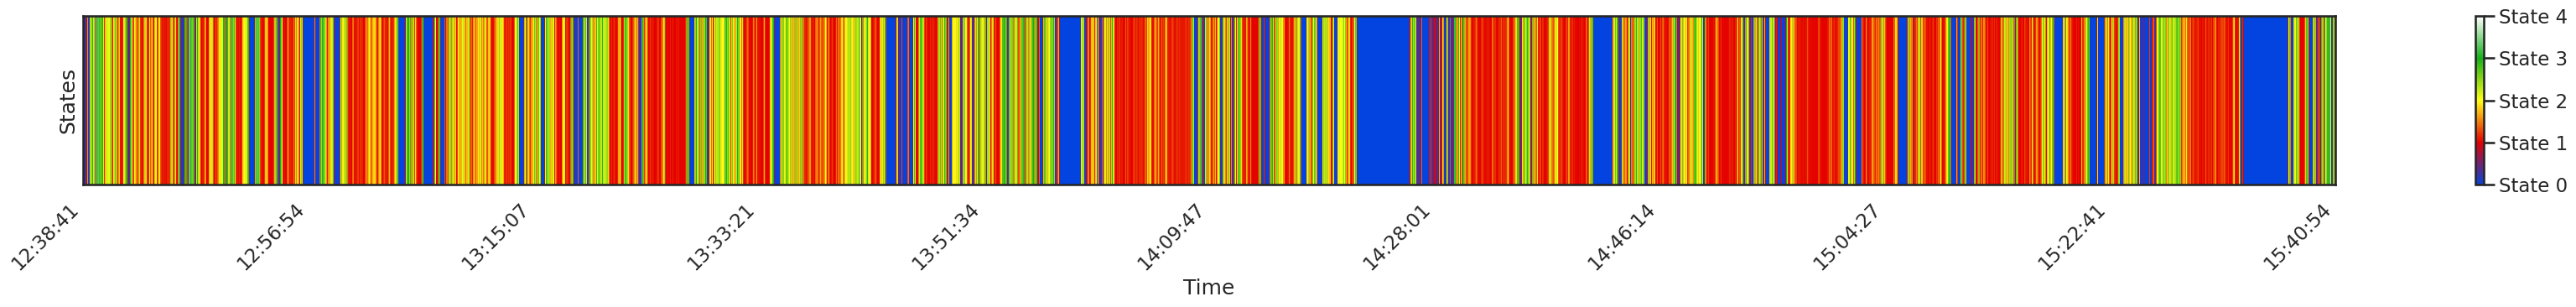

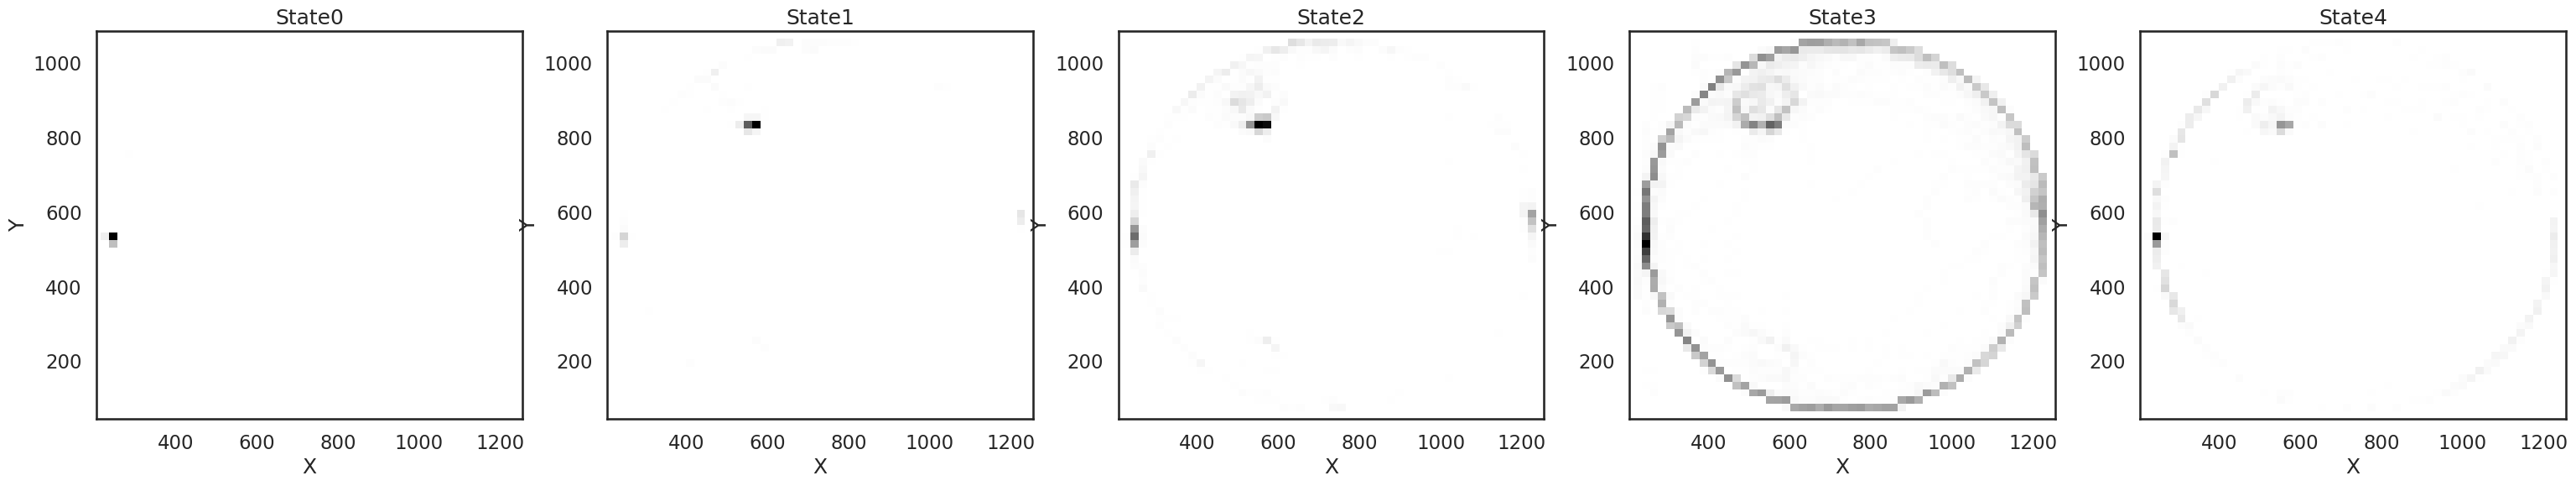

Overall: 


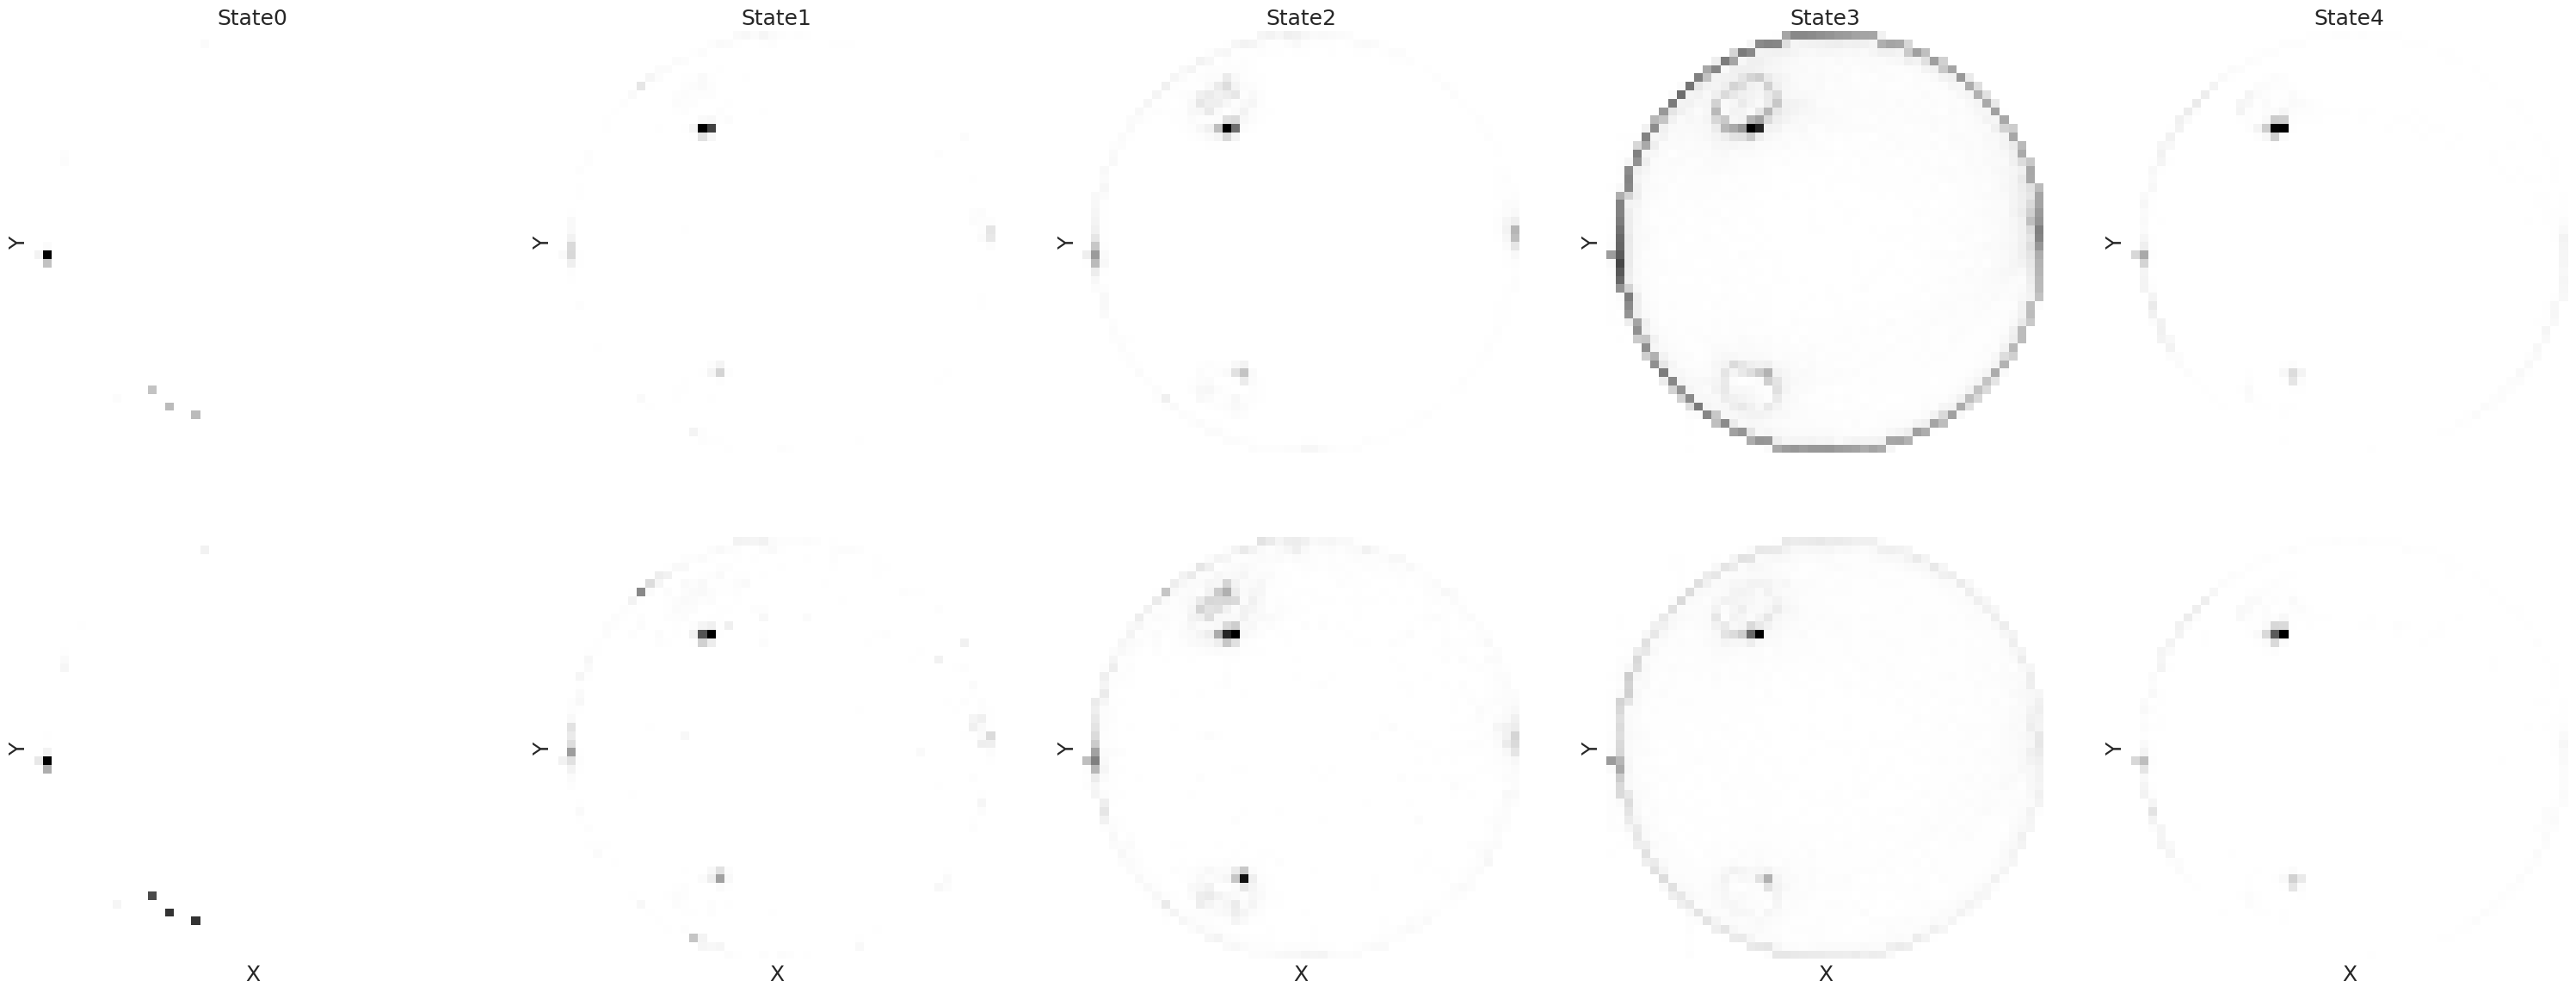

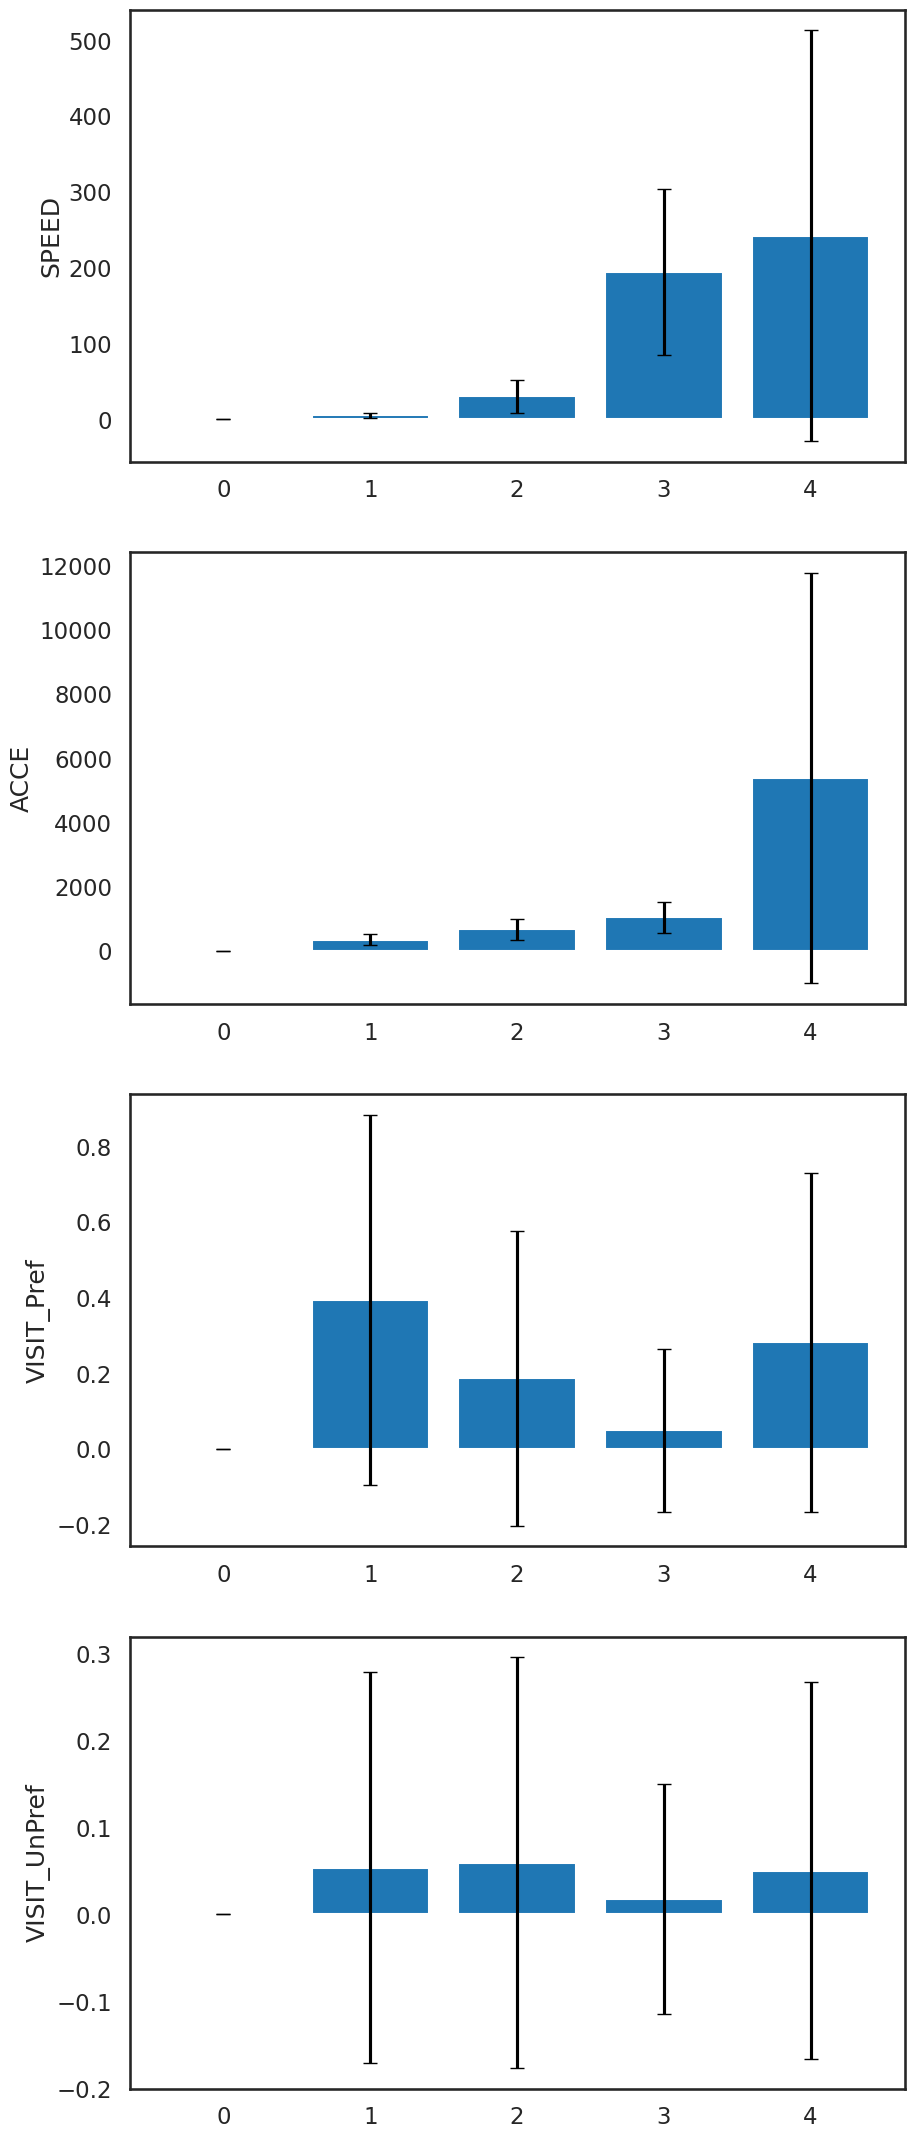

In [78]:
X, Y, SPEED, ACCE, VISIT_Pref, VISIT_UnPref = [np.array([]) for _ in range(N)], [np.array([]) for _ in range(N)], [np.array([]) for _ in range(N)], [np.array([]) for _ in range(N)], [np.array([]) for _ in range(N)], [np.array([]) for _ in range(N)]
HEATMAP = [[] for _ in range(N)]

for session, j in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    if j in short_sessions_patch1:
        title = 'ShortSession'+str(j)
        print(title)
        mouse_pos = pd.read_parquet(title+'mousepos.parquet', engine='pyarrow')
        mouse_pos = mouse_pos[mouse_pos['smoothed_acceleration'] <= 60000]
        mouse_pos = DeleteRows(mouse_pos)
            
        obs = np.array(mouse_pos[feature])
        states = hmm.most_likely_states(obs)
        
        new_values = np.empty_like(states)
        for i, val in enumerate(index): new_values[states == val] = i
        states = new_values
            
        PlotStates(states, mouse_pos)
        
        x = mouse_pos['smoothed_position_x']
        y = mouse_pos['smoothed_position_y']
        speed = mouse_pos['smoothed_speed']
        acceleration = mouse_pos['smoothed_acceleration']
        VisitPatch1 = mouse_pos['Patch1']
        VisitPatch2 = mouse_pos['Patch2']
        Patch_Pref = VisitPatch1 if np.mean(VisitPatch1) > np.mean(VisitPatch2) else VisitPatch2
        Patch_UnPref = VisitPatch1 if np.mean(VisitPatch1) < np.mean(VisitPatch2) else VisitPatch2
        
        for i in range(N):
            X[i] = np.concatenate([X[i], x[states==i]])
            Y[i] = np.concatenate([Y[i], y[states==i]])
            SPEED[i] = np.concatenate([SPEED[i], speed[states==i]])
            ACCE[i] = np.concatenate([ACCE[i], acceleration[states == i]])
            VISIT_Pref[i] = np.concatenate([VISIT_Pref[i], Patch_Pref[states == i]])
            VISIT_UnPref[i] = np.concatenate([VISIT_UnPref[i], Patch_UnPref[states == i]])
        
        fig, axs = plt.subplots(1, N, figsize = (N*8-2,6))
        for i in range(N):
            heatmap, xedges, yedges, img = axs[i].hist2d(x[states == i], y[states == i], bins=[50, 50], range=[[215, 1235], [65, 1065]], cmap='binary', density=True)
            heatmap = np.nan_to_num(heatmap)
            HEATMAP[i].append(heatmap)
            axs[i].set_xlim(205, 1255)
            axs[i].set_ylim(45, 1085)
            axs[i].set_title('State' + str(i))
            axs[i].set_xlabel('X')
            axs[i].set_ylabel('Y')
        plt.show()

print("Overall: ")    

fig, axs = plt.subplots(2, N, figsize = (N*8-2,14))
for i in range(N):
    combined_heatmaps = np.array(HEATMAP[i])
    average_heatmap, std_deviation_heatmap = np.mean(combined_heatmaps, axis=0), np.std(combined_heatmaps, axis=0)
    sns.heatmap(np.rot90(average_heatmap), ax=axs[0,i], cmap='binary', cbar = False)
    sns.heatmap(np.rot90(std_deviation_heatmap), ax=axs[1,i], cmap='binary', cbar = False)
    
    axs[0,i].set_xticks([])
    axs[0,i].set_yticks([])
    axs[1,i].set_xticks([])
    axs[1,i].set_yticks([])
    axs[0,i].set_ylabel('Y')
    axs[1,i].set_ylabel('Y')
    axs[1,i].set_xlabel('X')
    axs[0,i].set_title('State' + str(i))    
plt.show()

# Speed, Acceleration, Visits in Patch 1, Visits in Patch 2
fig, axs = plt.subplots(4, 1, figsize = (10, 4*7-1))
DATA = [SPEED, ACCE, VISIT_Pref, VISIT_UnPref]
FEATURE = ['SPEED', 'ACCE', 'VISIT_Pref', 'VISIT_UnPref']
for data, i in zip(DATA, range(len(DATA))):
    means = [np.mean(arr) for arr in data]
    std_devs = [np.std(arr) for arr in data]
    axs[i].bar(range(N), means, yerr=std_devs, capsize=5)
    axs[i].set_xticks(range(0, 5), ['0', '1', '2', '3','4'])
    axs[i].set_ylabel(FEATURE[i])
plt.show()

ShortSession0


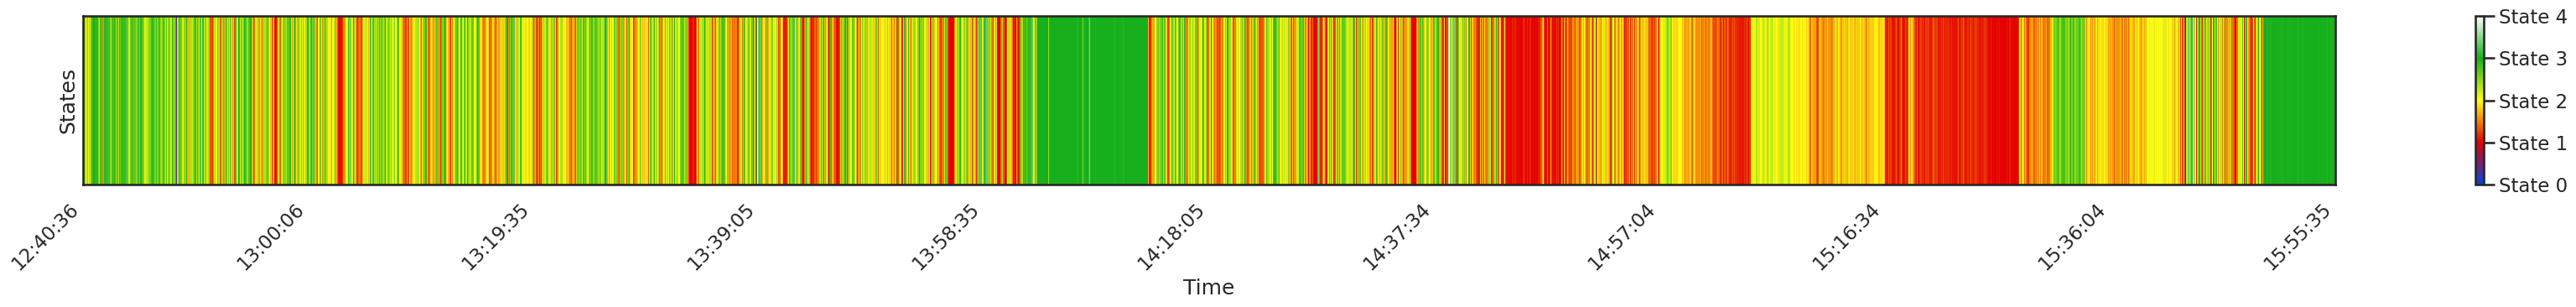

/nfs/nhome/live/zimol/anaconda3/envs/lds/lib/python3.9/site-packages/numpy/lib/histograms.py:1124: RuntimeWarning: invalid value encountered in true_divide
  hist /= s


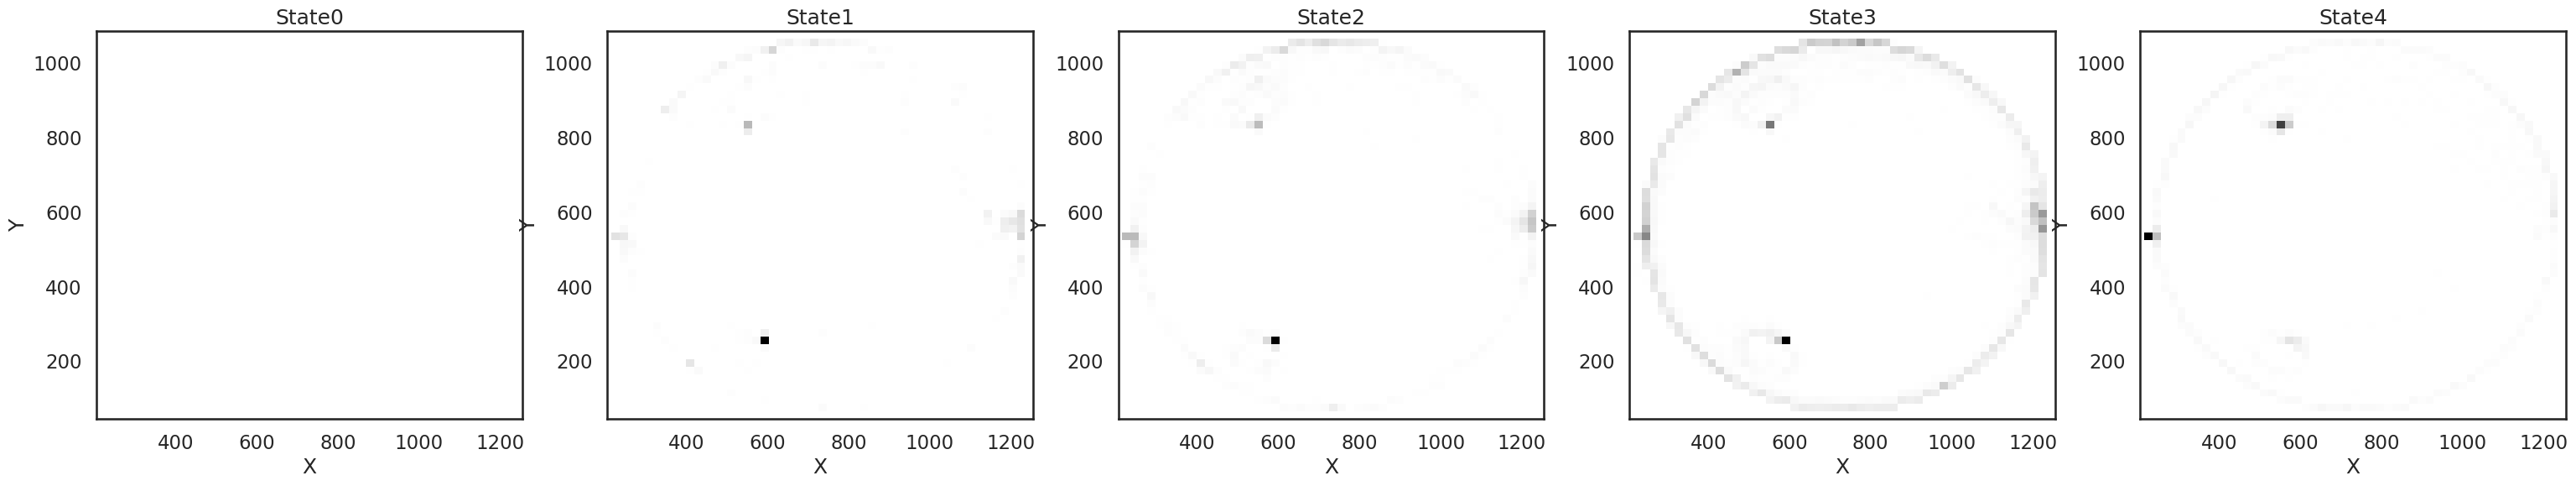

ShortSession5


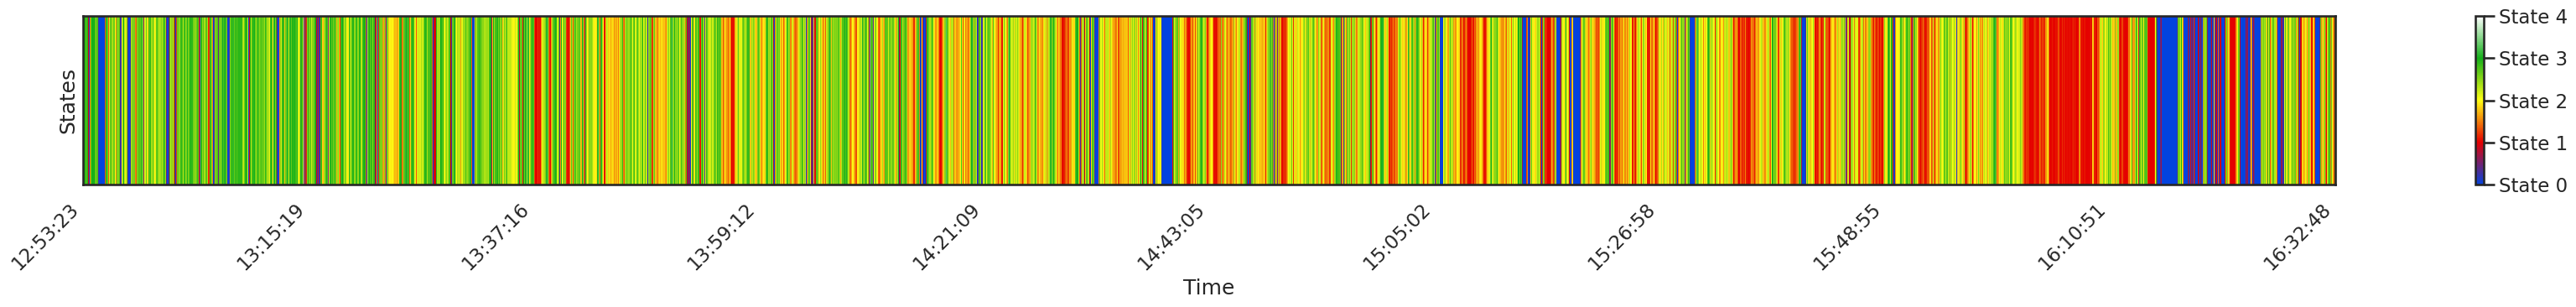

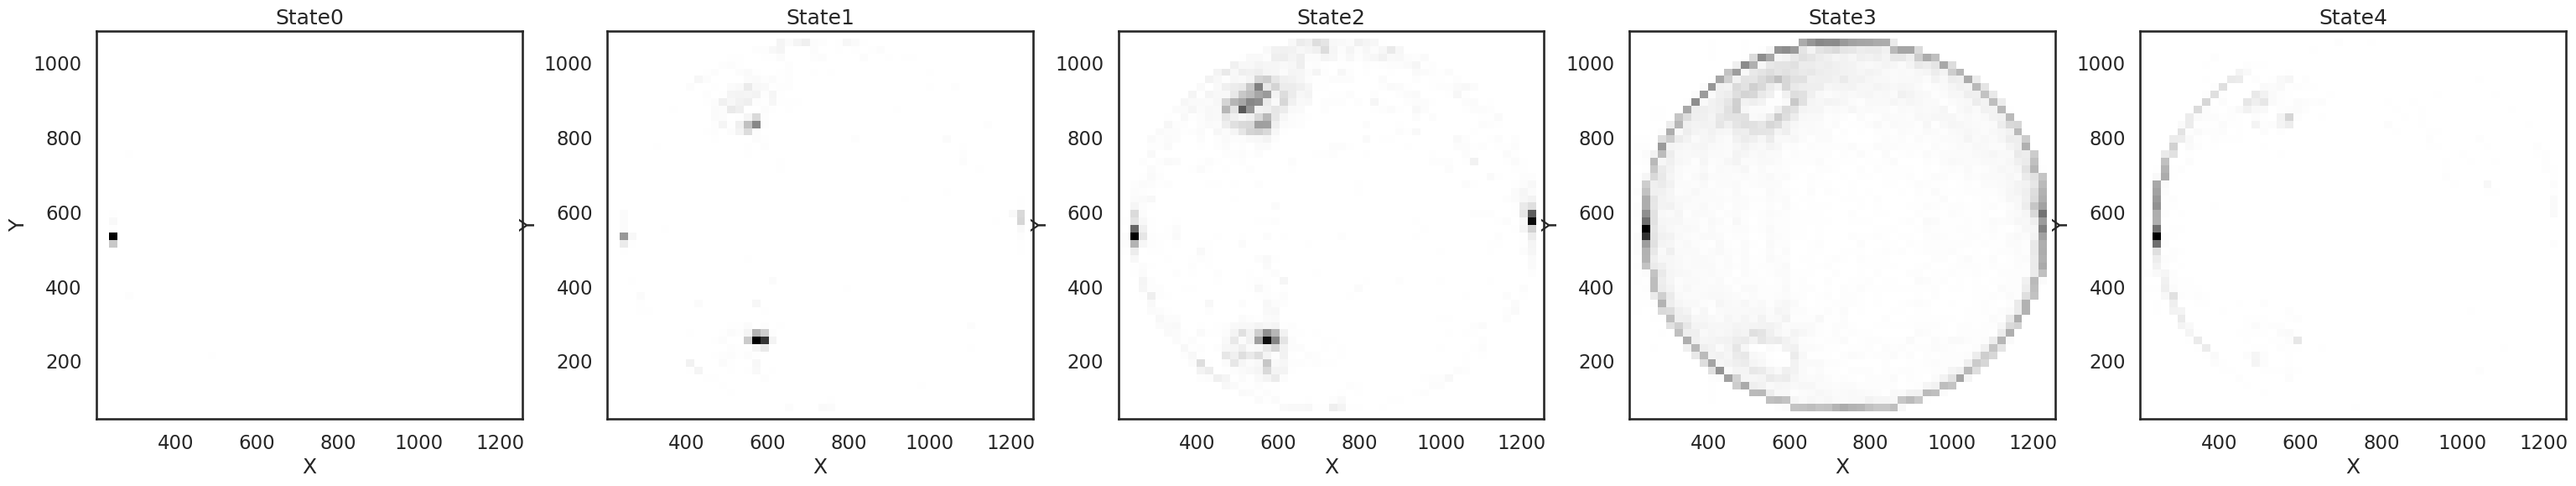

ShortSession6


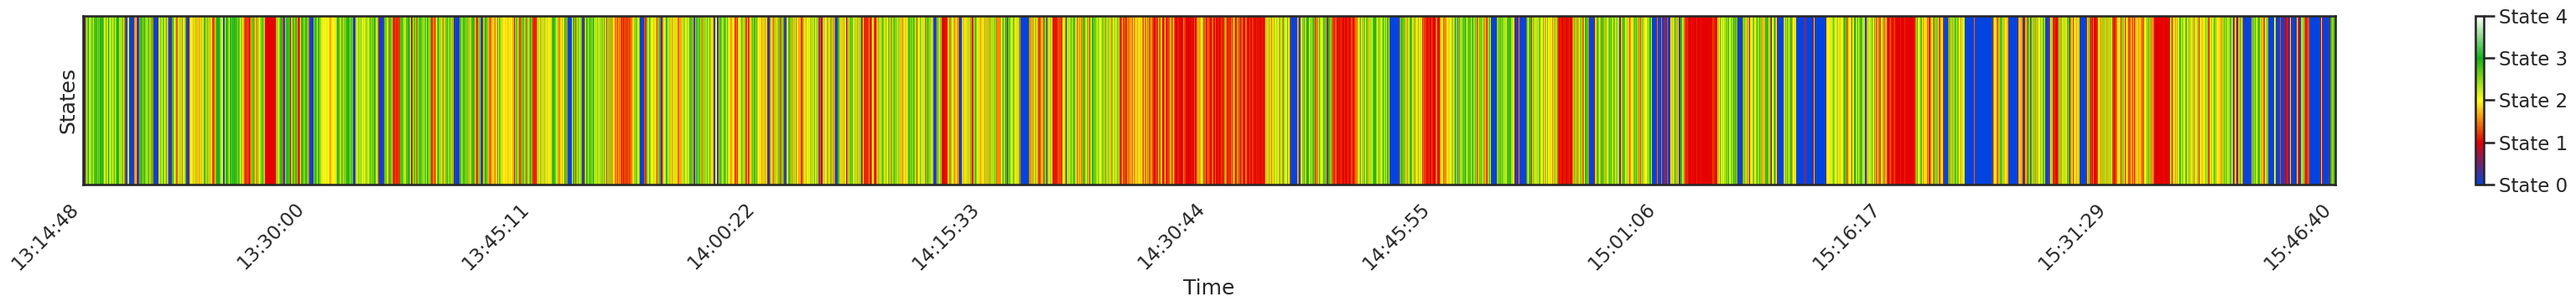

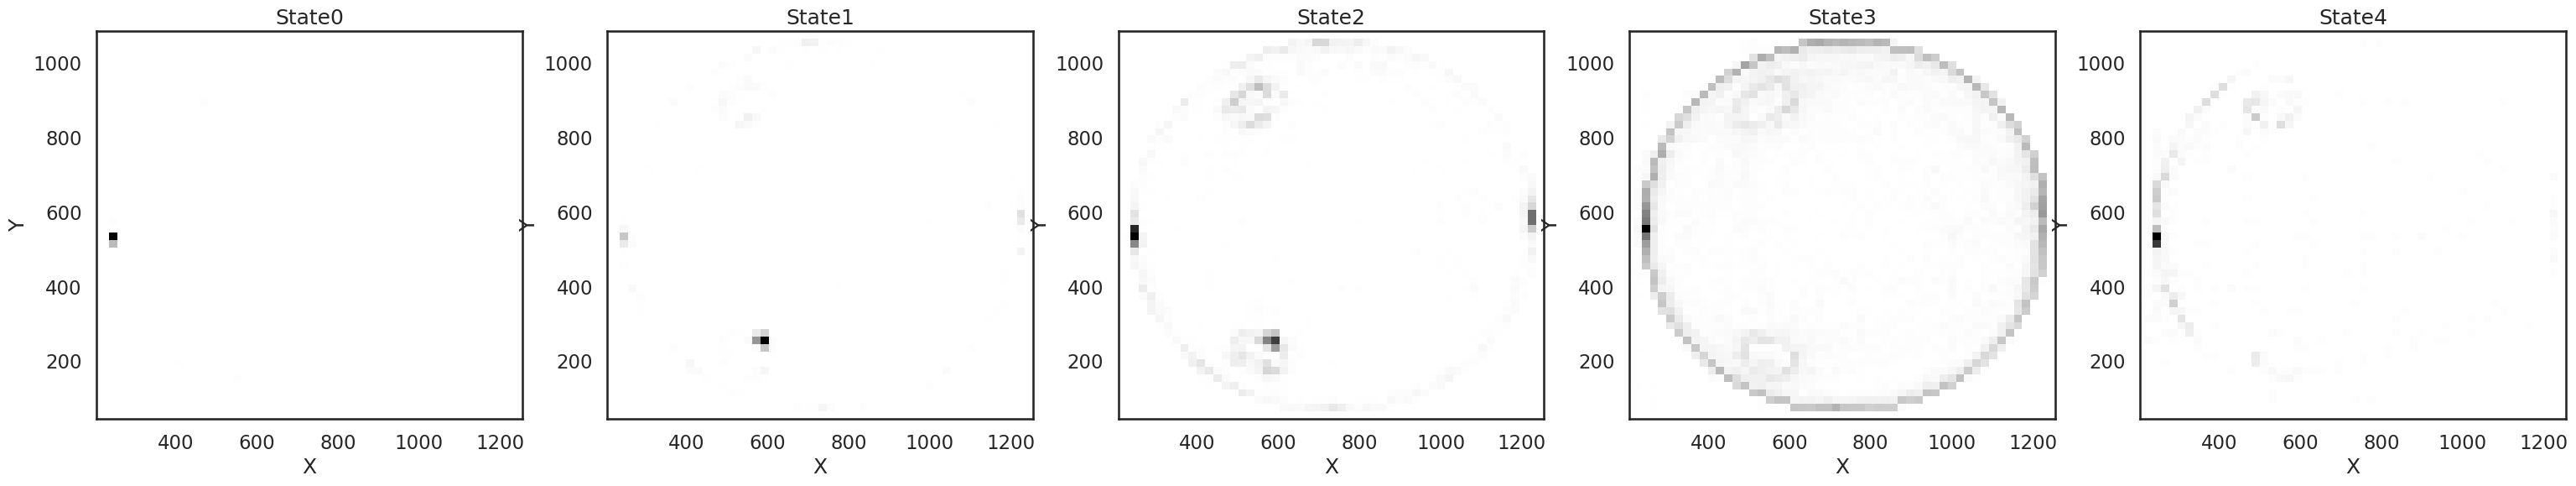

Overall: 


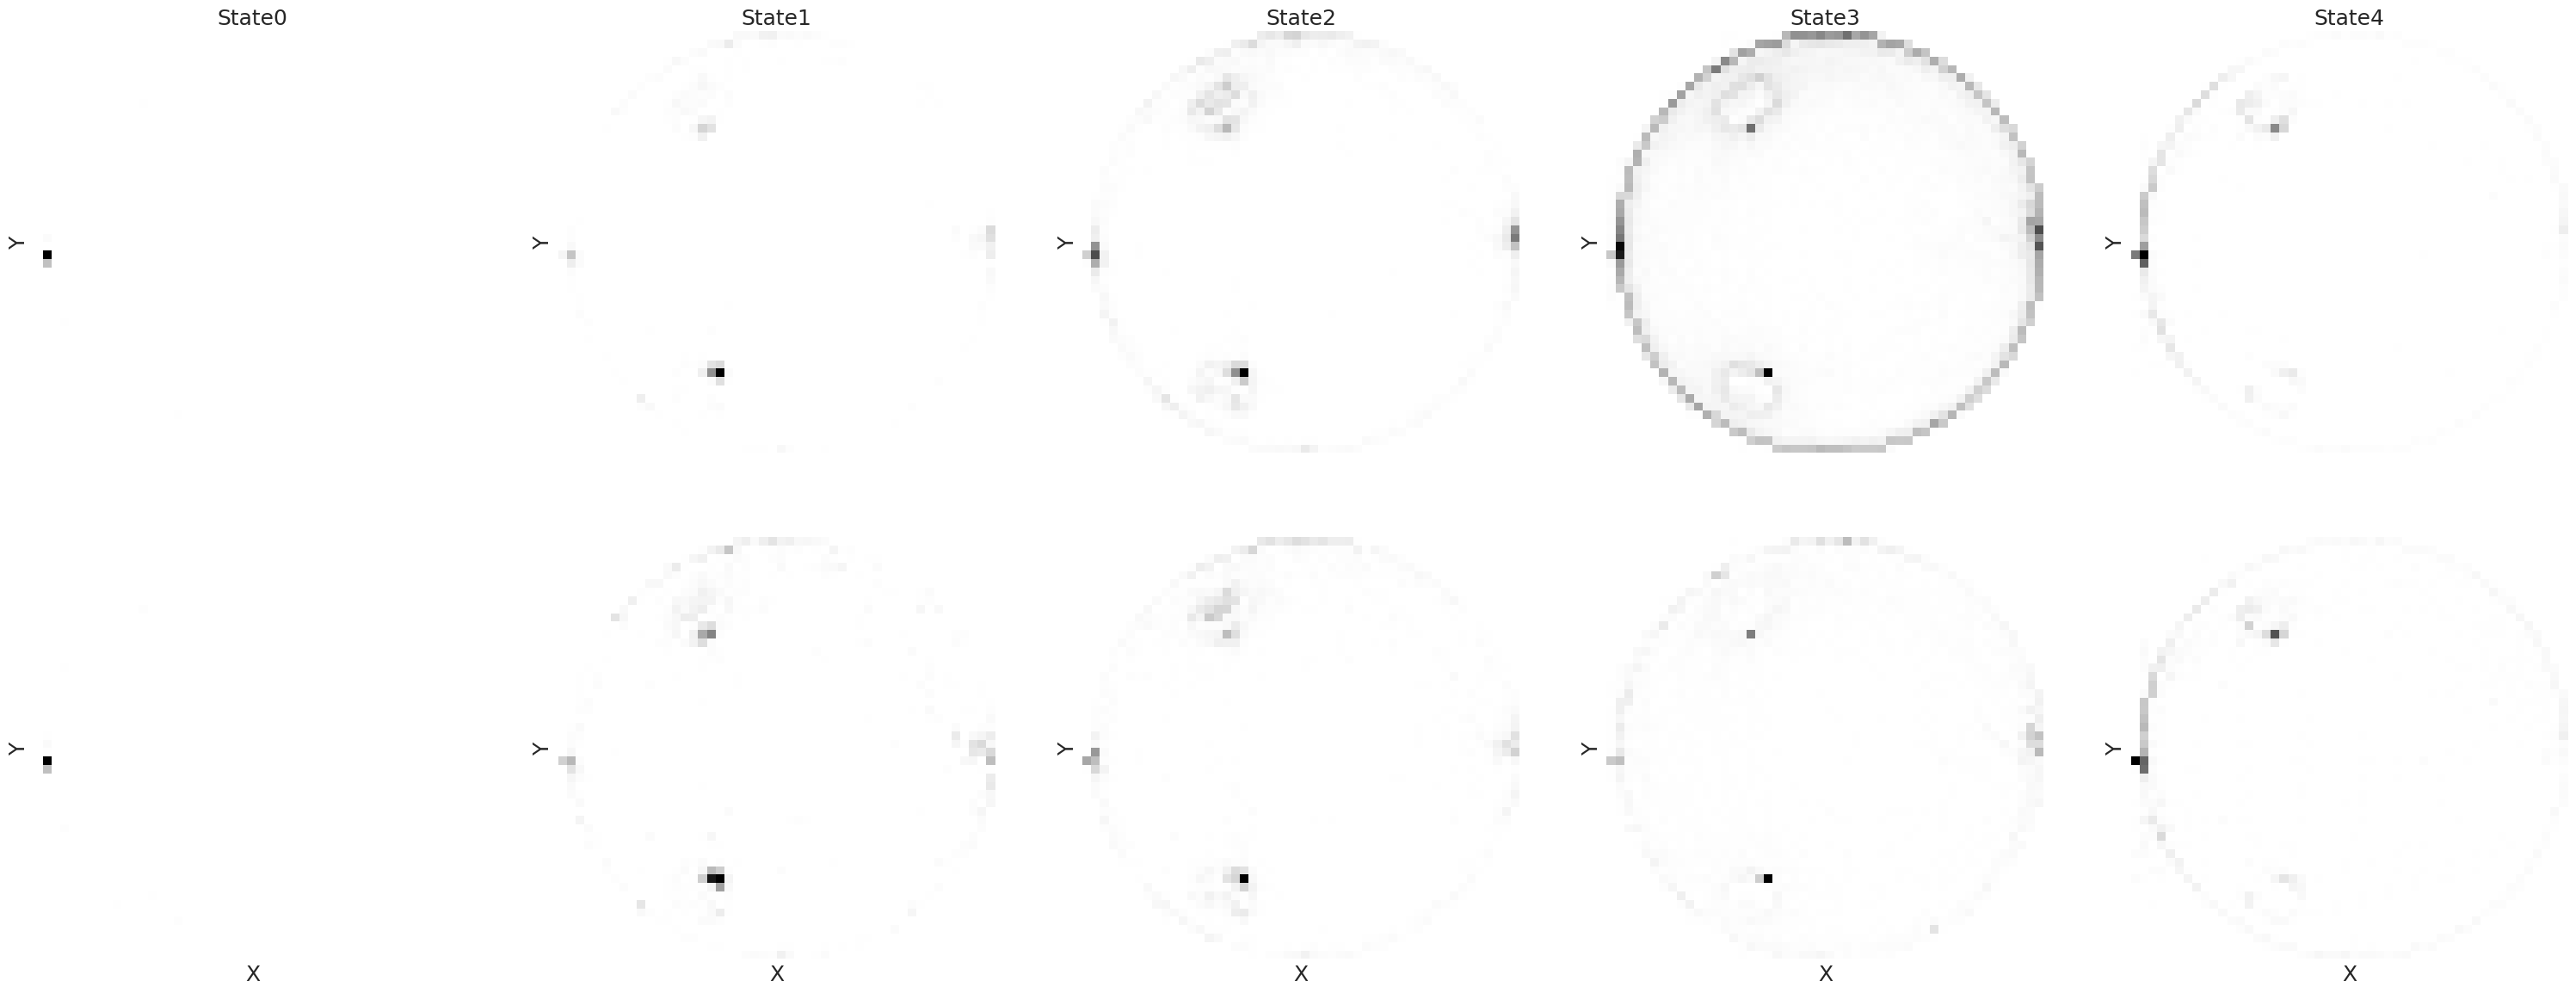

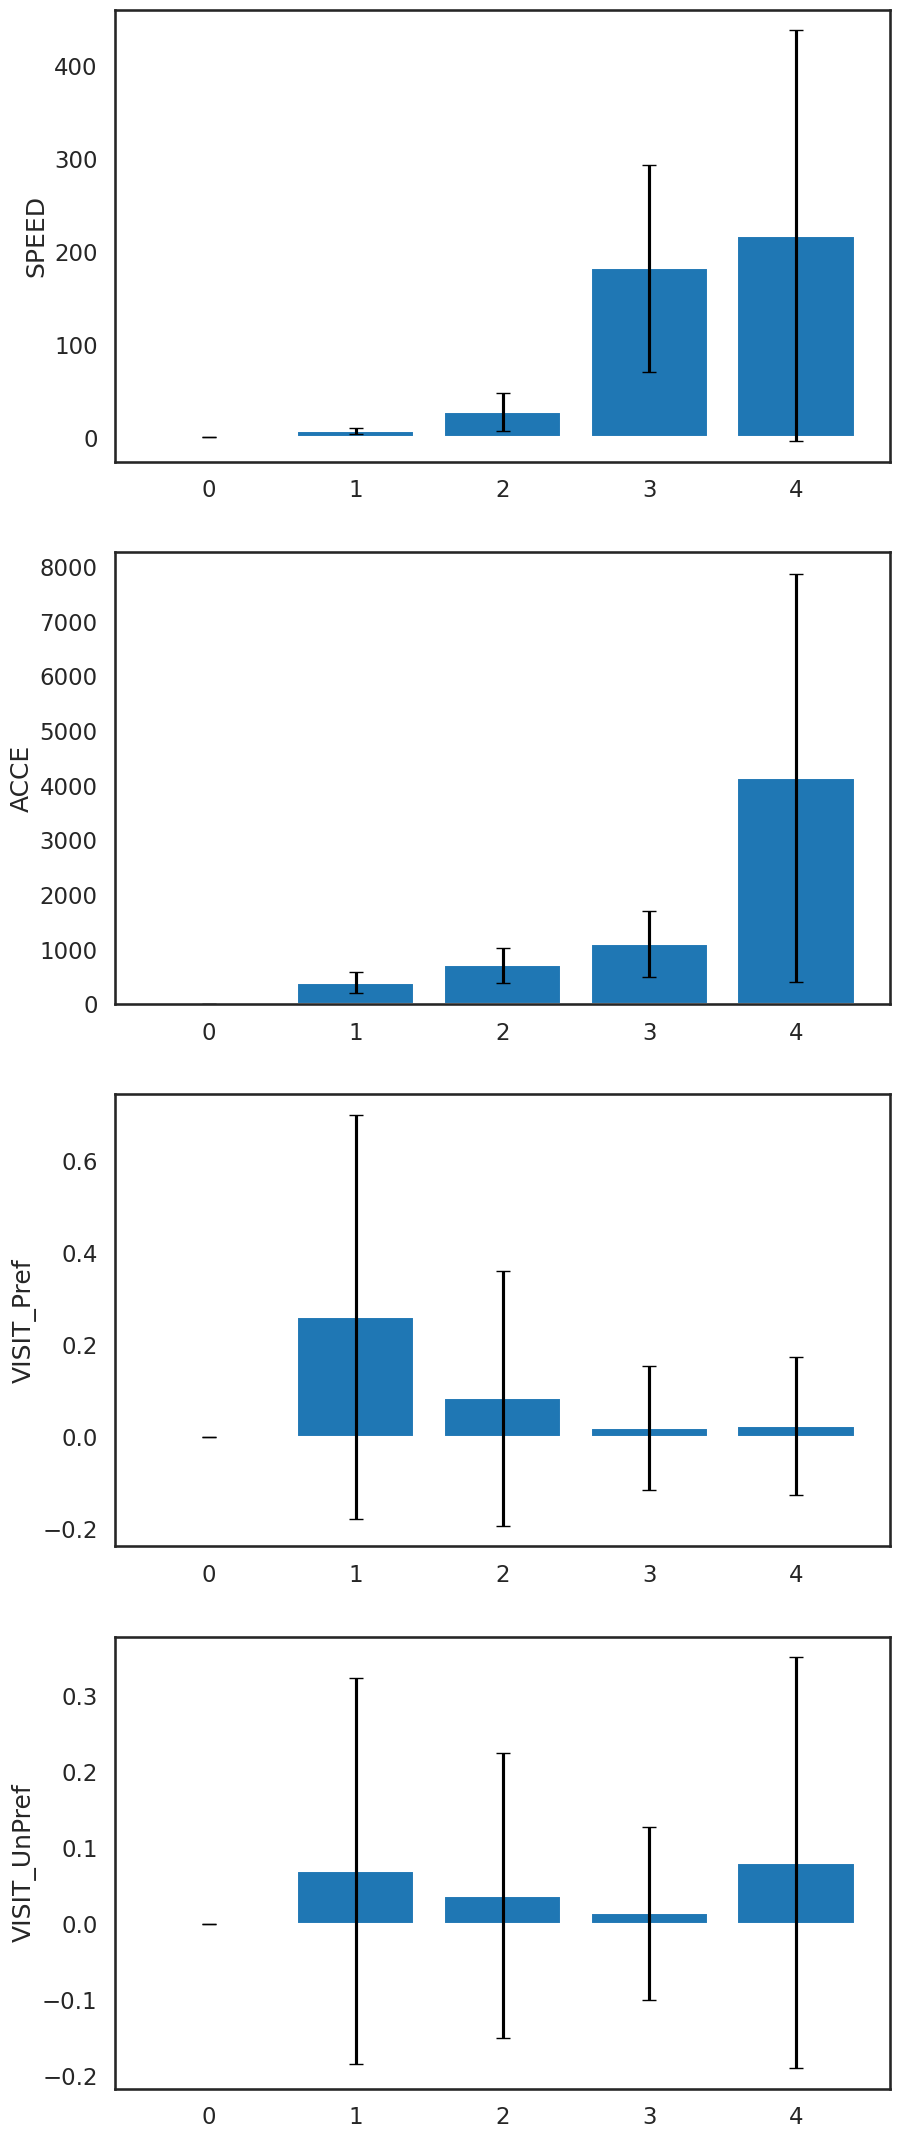

In [77]:
X, Y, SPEED, ACCE, VISIT_Pref, VISIT_UnPref = [np.array([]) for _ in range(N)], [np.array([]) for _ in range(N)], [np.array([]) for _ in range(N)], [np.array([]) for _ in range(N)], [np.array([]) for _ in range(N)], [np.array([]) for _ in range(N)]
HEATMAP = [[] for _ in range(N)]

for session, j in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    if j in short_sessions_patch2:
        title = 'ShortSession'+str(j)
        print(title)
        mouse_pos = pd.read_parquet(title+'mousepos.parquet', engine='pyarrow')
        mouse_pos = mouse_pos[mouse_pos['smoothed_acceleration'] <= 60000]
        mouse_pos = DeleteRows(mouse_pos)
            
        obs = np.array(mouse_pos[feature])
        states = hmm.most_likely_states(obs)
        
        new_values = np.empty_like(states)
        for i, val in enumerate(index): new_values[states == val] = i
        states = new_values
            
        PlotStates(states, mouse_pos)
        
        x = mouse_pos['smoothed_position_x']
        y = mouse_pos['smoothed_position_y']
        speed = mouse_pos['smoothed_speed']
        acceleration = mouse_pos['smoothed_acceleration']
        VisitPatch1 = mouse_pos['Patch1']
        VisitPatch2 = mouse_pos['Patch2']
        Patch_Pref = VisitPatch1 if np.mean(VisitPatch1) > np.mean(VisitPatch2) else VisitPatch2
        Patch_UnPref = VisitPatch1 if np.mean(VisitPatch1) < np.mean(VisitPatch2) else VisitPatch2
        
        for i in range(N):
            X[i] = np.concatenate([X[i], x[states==i]])
            Y[i] = np.concatenate([Y[i], y[states==i]])
            SPEED[i] = np.concatenate([SPEED[i], speed[states==i]])
            ACCE[i] = np.concatenate([ACCE[i], acceleration[states == i]])
            VISIT_Pref[i] = np.concatenate([VISIT_Pref[i], Patch_Pref[states == i]])
            VISIT_UnPref[i] = np.concatenate([VISIT_UnPref[i], Patch_UnPref[states == i]])
        
        fig, axs = plt.subplots(1, N, figsize = (N*8-2,6))
        for i in range(N):
            heatmap, xedges, yedges, img = axs[i].hist2d(x[states == i], y[states == i], bins=[50, 50], range=[[215, 1235], [65, 1065]], cmap='binary', density=True)
            heatmap = np.nan_to_num(heatmap)
            HEATMAP[i].append(heatmap)
            axs[i].set_xlim(205, 1255)
            axs[i].set_ylim(45, 1085)
            axs[i].set_title('State' + str(i))
            axs[i].set_xlabel('X')
            axs[i].set_ylabel('Y')
        plt.show()

print("Overall: ")    

fig, axs = plt.subplots(2, N, figsize = (N*8-2,14))
for i in range(N):
    combined_heatmaps = np.array(HEATMAP[i])
    average_heatmap, std_deviation_heatmap = np.mean(combined_heatmaps, axis=0), np.std(combined_heatmaps, axis=0)
    sns.heatmap(np.rot90(average_heatmap), ax=axs[0,i], cmap='binary', cbar = False)
    sns.heatmap(np.rot90(std_deviation_heatmap), ax=axs[1,i], cmap='binary', cbar = False)
    
    axs[0,i].set_xticks([])
    axs[0,i].set_yticks([])
    axs[1,i].set_xticks([])
    axs[1,i].set_yticks([])
    axs[0,i].set_ylabel('Y')
    axs[1,i].set_ylabel('Y')
    axs[1,i].set_xlabel('X')
    axs[0,i].set_title('State' + str(i))    
plt.show()

# Speed, Acceleration, Visits in Patch 1, Visits in Patch 2
fig, axs = plt.subplots(4, 1, figsize = (10, 4*7-1))
DATA = [SPEED, ACCE, VISIT_Pref, VISIT_UnPref]
FEATURE = ['SPEED', 'ACCE', 'VISIT_Pref', 'VISIT_UnPref']
for data, i in zip(DATA, range(len(DATA))):
    means = [np.mean(arr) for arr in data]
    std_devs = [np.std(arr) for arr in data]
    axs[i].bar(range(N), means, yerr=std_devs, capsize=5)
    axs[i].set_xticks(range(0, 5), ['0', '1', '2', '3','4'])
    axs[i].set_ylabel(FEATURE[i])
plt.show()

## Long

In [ ]:
def assign_marker(dt):
    if dt.hour >= 19:  # If time is 7 PM or later, the segment belongs to the next day
        return (dt + pd.Timedelta(days=1)).date()
    else:  # If time is before 7 PM, the segment belongs to the current day
        return dt.date()
    
def calculate_cr(hour):
    if 8 <= hour < 19:  # From 8 AM to 7 PM
        return 0
    elif 19 <= hour < 20:
        return (hour - 19)
    elif 7 <= hour < 8: 
        return 1 - (hour - 7)
    else:
        return 1

In [12]:
'''for session, i in zip(list(long_sessions.itertuples()), range(len(long_sessions))):
    title = 'LongSession'+str(i)
    print(title)
                    
    start, end = session.enter, session.exit
    mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)
    mouse_pos = kinematics.ProcessRawData(mouse_pos, root, start, end)
            
    start, end = mouse_pos.index[0], mouse_pos.index[-1]
                
    patch.AddKinematics(title, mouse_pos)
    
    mouse_pos = mouse_pos[mouse_pos['smoothed_speed'] <= 2000]
            
    weight = api.load(root, exp02.Nest.WeightSubject, start=start, end=end)
    patch.AddWeight(mouse_pos, weight)
            
    pellets_patch1 = api.load(root, exp02.Patch1.DeliverPellet, start=start, end=end)
    pellets_patch2 = api.load(root, exp02.Patch2.DeliverPellet, start=start, end=end)
                
    patch.InPatch(mouse_pos, pellets_patch1, pellets_patch2)
        
    mouse_pos.to_parquet(title+'mousepos.parquet', engine='pyarrow')'''

"for session, i in zip(list(long_sessions.itertuples()), range(len(long_sessions))):\n    title = 'LongSession'+str(i)\n    print(title)\n                    \n    start, end = session.enter, session.exit\n    mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)\n    mouse_pos = kinematics.ProcessRawData(mouse_pos, root, start, end)\n            \n    start, end = mouse_pos.index[0], mouse_pos.index[-1]\n                \n    patch.AddKinematics(title, mouse_pos)\n    \n    mouse_pos = mouse_pos[mouse_pos['smoothed_speed'] <= 2000]\n            \n    weight = api.load(root, exp02.Nest.WeightSubject, start=start, end=end)\n    patch.AddWeight(mouse_pos, weight)\n            \n    pellets_patch1 = api.load(root, exp02.Patch1.DeliverPellet, start=start, end=end)\n    pellets_patch2 = api.load(root, exp02.Patch2.DeliverPellet, start=start, end=end)\n                \n    patch.InPatch(mouse_pos, pellets_patch1, pellets_patch2)\n        \n    mouse_pos.to_parquet(title

In [ ]:
for session, i in zip(list(long_sessions.itertuples()), range(len(long_sessions))):
    title = 'LongSession'+str(i)
    print(title)
                    
    start, end = session.enter, session.exit
    mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)
    mouse_pos = kinematics.ProcessRawData(mouse_pos, root, start, end)
            
    start, end = mouse_pos.index[0], mouse_pos.index[-1]
                
    patch.AddKinematics(title, mouse_pos)
    
    mouse_pos = mouse_pos[mouse_pos['smoothed_speed'] <= 2000]
            
    weight = api.load(root, exp02.Nest.WeightSubject, start=start, end=end)
    patch.AddWeight(mouse_pos, weight)
            
    pellets_patch1 = api.load(root, exp02.Patch1.DeliverPellet, start=start, end=end)
    pellets_patch2 = api.load(root, exp02.Patch2.DeliverPellet, start=start, end=end)
                
    patch.InPatch(mouse_pos, pellets_patch1, pellets_patch2)
        
    mouse_pos.to_parquet(title+'mousepos.parquet', engine='pyarrow')

"for session, i in zip(list(long_sessions.itertuples()), range(len(long_sessions))):\n    title = 'LongSession'+str(i)\n    print(title)\n                    \n    start, end = session.enter, session.exit\n    mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)\n    mouse_pos = kinematics.ProcessRawData(mouse_pos, root, start, end)\n            \n    start, end = mouse_pos.index[0], mouse_pos.index[-1]\n                \n    patch.AddKinematics(title, mouse_pos)\n    \n    mouse_pos = mouse_pos[mouse_pos['smoothed_speed'] <= 2000]\n            \n    weight = api.load(root, exp02.Nest.WeightSubject, start=start, end=end)\n    patch.AddWeight(mouse_pos, weight)\n            \n    pellets_patch1 = api.load(root, exp02.Patch1.DeliverPellet, start=start, end=end)\n    pellets_patch2 = api.load(root, exp02.Patch2.DeliverPellet, start=start, end=end)\n                \n    patch.InPatch(mouse_pos, pellets_patch1, pellets_patch2)\n        \n    mouse_pos.to_parquet(title

In [8]:
for session, i in zip(list(long_sessions.itertuples()), range(len(long_sessions))):
    if i == 0:
        title = 'LongSession'+str(i)
        print(title)
                            
        start, end = session.enter, session.exit
        mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)

LongSession0


/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/aeon/io/api.py:145: UserWarning: data index for CameraTop_200_* contains out-of-order timestamps!
  warnings.warn(f"data index for {reader.pattern} contains out-of-order timestamps!")


In [9]:
mouse_pos = kinematics.ProcessRawData(mouse_pos, root, start, end)

In [10]:
start, end = mouse_pos.index[0], mouse_pos.index[-1]
patch.AddKinematics(title, mouse_pos)

In [ ]:
# Apply the function to each row to create the grouping marker
mouse_pos['group_marker'] = mouse_pos.index.map(assign_marker)

# Group by the marker and create a DataFrame for each group
N = 4
feature = ['weight', 'smoothed_speed', 'smoothed_acceleration', 'CR']
for _, group_df in mouse_pos.groupby('group_marker'):
    mouse_pos_sub = group_df.drop(columns='group_marker')
    
    mouse_pos_sub = mouse_pos_sub[mouse_pos_sub['smoothed_speed'] <= 2000]
    mouse_pos_sub = mouse_pos_sub[mouse_pos_sub['smoothed_acceleration'] <= 60000]
    mouse_pos_sub = DeleteRows(mouse_pos_sub)
    
    start, end = mouse_pos_sub.index[0], mouse_pos_sub.index[-1]
    
    weight = api.load(root, exp02.Nest.WeightSubject, start=start, end=end)
    patch.AddWeight(mouse_pos_sub, weight)
    
    pellets_patch1 = api.load(root, exp02.Patch1.DeliverPellet, start=start, end=end)
    pellets_patch2 = api.load(root, exp02.Patch2.DeliverPellet, start=start, end=end)   
    patch.InPatch(mouse_pos_sub, pellets_patch1, pellets_patch2)
    
    mouse_pos_sub['CR'] = mouse_pos_sub.index.hour.apply(calculate_cr)
    
    X, Y, SPEED, ACCE, VISIT1, VISIT2 = [np.array([]) for _ in range(N)], [np.array([]) for _ in range(N)], [np.array([]) for _ in range(N)], [np.array([]) for _ in range(N)], [np.array([]) for _ in range(N)], [np.array([]) for _ in range(N)]
    
    obs = np.array(mouse_pos_sub[feature])
    hmm, states, transition_mat, lls = FitHMM(obs, num_states = N, n_iters = 50)
                
    PlotTransition(transition_mat)
    PlotStates(states, mouse_pos_sub)
            
    x = mouse_pos_sub['smoothed_position_x']
    y = mouse_pos_sub['smoothed_position_y']
    speed = mouse_pos_sub['smoothed_speed']
    acceleration = mouse_pos_sub['smoothed_acceleration']
    VisitPatch1 = mouse_pos_sub['Patch1']
    VisitPatch2 = mouse_pos_sub['Patch2']
            
    for i in range(N):
        X[i] = np.concatenate([X[i], x[states==i]])
        Y[i] = np.concatenate([Y[i], y[states==i]])
        SPEED[i] = np.concatenate([SPEED[i], speed[states==i]])
        ACCE[i] = np.concatenate([ACCE[i], acceleration[states == i]])
        VISIT1[i] = np.concatenate([VISIT1[i], VisitPatch1[states == i]])
        VISIT2[i] = np.concatenate([VISIT2[i], VisitPatch2[states == i]])

            
    # Position
    fig, axs = plt.subplots(1, N, figsize = (N*8-2,6))
    for i in range(N):
        heatmap, xedges, yedges, img = axs[i].hist2d(X[i], Y[i], bins=[50, 50], range=[[235, 1235], [65, 1065]], cmap='binary', density=True)
        axs[i].set_xlim(225, 1255)
        axs[i].set_ylim(45, 1085)
        axs[i].set_title('State' + str(i))
        axs[i].set_xlabel('X')
        axs[i].set_ylabel('Y')
    plt.show()

    # Speed, Acceleration, Visits in Patch 1, Visits in Patch 2
    fig, axs = plt.subplots(4, 1, figsize = (10, 4*7-1))
    DATA = [SPEED, ACCE, VISIT1, VISIT2]
    FEATURE = ['SPEED', 'ACCE', 'VISIT1', 'VISIT2']
    for data, i in zip(DATA, range(len(DATA))):
        means = [np.mean(arr) for arr in data]
        std_devs = [np.std(arr) for arr in data]
        axs[i].bar(range(N), means, yerr=std_devs, capsize=5)
        axs[i].set_xticks(range(0, 4), ['0', '1', '2', '3'])
        axs[i].set_ylabel(FEATURE[i])
    plt.show()